In [1]:
import pandas as pd
import ast
import numpy as np
import os

## Entity normalization tests

### Load SNOMED terminology
Note: 
- SNOMED CT is the most comprehensive, multilingual clinical healthcare terminology in the world. See https://www.snomed.org/five-step-briefing
- SNOMED CT is a terminology that can cross-map to other international terminologies, classifications and code systems. Maps are associations between particular concepts or terms in one system and concepts or terms in another system that have the same (or similar) meaning. See https://www.snomed.org/maps
- Downloaded Current International Edition (RF2 files) from: https://www.nlm.nih.gov/healthit/snomedct/international.html
- we use the snapshot release: A snapshot release is a release type in which the release files contain only the most recent version of every component and reference set member released, as at the release date. See https://confluence.ihtsdotools.org/display/DOCRELFMT/3.2+Release+Types

In [2]:
import networkx as nx
from tqdm import tqdm
from src.Snomed import Snomed
# code from https://github.com/cambridgeltl/sapbert/tree/main

In [3]:
release_id = '20240401'
SNOMED_PATH = './data/snomed/SnomedCT_InternationalRF2_PRODUCTION_20240401T120000Z' # you need to download your own SNOMED distribution
snomed = Snomed(SNOMED_PATH, release_id=release_id)
snomed.load_snomed()

In [4]:
snomed_sf_id_pairs = []

for snomed_id in tqdm(snomed.graph.nodes):
    
    node_descs = snomed.index_definition[snomed_id]
    for d in node_descs:
        snomed_sf_id_pairs.append((d, snomed_id))

print(len(snomed_sf_id_pairs))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366908/366908 [00:00<00:00, 2440067.44it/s]

971409


In [5]:
snomed_sf_id_pairs[:10]


[('Neoplasm of anterior aspect of epiglottis', '126813005'),
 ('Neoplasm of anterior aspect of epiglottis (disorder)', '126813005'),
 ('Neoplasm of junctional region of epiglottis', '126814004'),
 ('Neoplasm of junctional region of epiglottis (disorder)', '126814004'),
 ('Neoplasm of lateral wall of oropharynx', '126815003'),
 ('Neoplasm of lateral wall of oropharynx (disorder)', '126815003'),
 ('Neoplasm of posterior wall of oropharynx', '126816002'),
 ('Neoplasm of posterior wall of oropharynx (disorder)', '126816002'),
 ('Tumour of posterior wall of oropharynx', '126816002'),
 ('Tumor of posterior wall of oropharynx', '126816002')]

In [6]:
snomed_sf_id_pairs_100k = snomed_sf_id_pairs[:100000] # for simplicity

all_names = [p[0] for p in snomed_sf_id_pairs]
all_ids = [p[1] for p in snomed_sf_id_pairs]

In [7]:
all_names[:10]


['Neoplasm of anterior aspect of epiglottis',
 'Neoplasm of anterior aspect of epiglottis (disorder)',
 'Neoplasm of junctional region of epiglottis',
 'Neoplasm of junctional region of epiglottis (disorder)',
 'Neoplasm of lateral wall of oropharynx',
 'Neoplasm of lateral wall of oropharynx (disorder)',
 'Neoplasm of posterior wall of oropharynx',
 'Neoplasm of posterior wall of oropharynx (disorder)',
 'Tumour of posterior wall of oropharynx',
 'Tumor of posterior wall of oropharynx']

In [8]:
all_ids[:10]


['126813005',
 '126813005',
 '126814004',
 '126814004',
 '126815003',
 '126815003',
 '126816002',
 '126816002',
 '126816002',
 '126816002']

### Load SAPBert

In [9]:
from transformers import AutoTokenizer, AutoModel 
import torch
from scipy.spatial.distance import cdist


In [10]:
tokenizer = AutoTokenizer.from_pretrained("cambridgeltl/SapBERT-from-PubMedBERT-fulltext")  
model = AutoModel.from_pretrained("cambridgeltl/SapBERT-from-PubMedBERT-fulltext")

#### encode snomed labels -> once!

In [13]:
bs = 128  # Batch size for processing
large_batch_size = 100000  # Size of the large batch to process each time

def process_and_save_batch(name_subset, batch_idx):
    all_reps = []
    for i in tqdm(range(0, len(name_subset), bs)):
        toks = tokenizer.batch_encode_plus(name_subset[i:i+bs], 
                                           padding="max_length", 
                                           max_length=25, 
                                           truncation=True,
                                           return_tensors="pt")
        # If using a GPU, uncomment the following lines
        # toks_cuda = {k: v.cuda() for k, v in toks.items()}
        # output = model(**toks_cuda)
        
        # For CPU usage (or adjust as needed for your GPU setup)
        output = model(**toks)
        cls_rep = output[0][:,0,:]
        all_reps.append(cls_rep.cpu().detach().numpy())
    
    all_reps_emb_full = np.concatenate(all_reps, axis=0)
    # Save to a binary file using numpy
    np.save(f'./data/embeddings/snomed_normalization/all_reps_emb_full_batch_{batch_idx}.npy', all_reps_emb_full)

# Process all names in chunks of 100000
for batch_start in range(0, len(all_names), large_batch_size):
    batch_end = min(batch_start + large_batch_size, len(all_names))
    name_subset = all_names[batch_start:batch_end]
    process_and_save_batch(name_subset, batch_start // large_batch_size)

In [14]:
# Define the directory where your files are stored
directory_path = './data/embeddings/snomed_normalization'

# List all files in the directory that match the pattern
files = [f for f in os.listdir(directory_path) if f.startswith('all_reps_emb_full_batch_') and f.endswith('.npy')]

# Sort files to maintain the order, especially important if the batch index is used in processing
files.sort()

# Initialize an empty list to hold the data from each file
all_data = []

# Load each file and append the data to the list
for file in files:
    file_path = os.path.join(directory_path, file)
    data = np.load(file_path)
    all_data.append(data)

# Concatenate all the arrays from the list into one
all_reps_emb_full = np.concatenate(all_data, axis=0)

## Test Mapping within SNOMED hieararchies

In [692]:
import pandas as pd
import networkx as nx

# Load data from a CSV file
file_path = 'data/snomed/SnomedCT_InternationalRF2_PRODUCTION_20240401T120000Z/Snapshot/Terminology/sct2_Relationship_Snapshot_INT_20240401.txt'
data = pd.read_csv(file_path, delimiter='\t')

# Filter data for active=1 and typeId=116680003 (IS_A relationships)
filtered_data = data[(data['active'] == 1) & (data['typeId'] == 116680003)]

# Create a directed graph
G = nx.DiGraph()

# Add edges from sourceId to destinationId
for idx, row in filtered_data.iterrows():
    G.add_edge(row['sourceId'], row['destinationId'])

# Generate a dictionary of all nodes with their reachable nodes
#all_hierarchies = {node: list(nx.descendants(G, node)) for node in G.nodes}

# Generate a dictionary of all nodes with their reachable and originating nodes
node_list = []
for node in G.nodes:
    descendants = list(nx.descendants(G, node))  # Nodes reachable from 'node'
    ancestors = list(nx.ancestors(G, node))  # Nodes that can reach 'node'
    node_list.append([node, descendants, ancestors])

# Create DataFrame from the list
hierarchies_df = pd.DataFrame(node_list, columns=['Node', 'Parents', 'Children'])


# Optionally, convert to a DataFrame for better visualization or output
#hierarchies_df = pd.DataFrame(list(all_hierarchies.items()), columns=['Node', 'Related Nodes'])


In [693]:
hierarchies_df

,Node,Parents,Children
0,10000006,"[302292003, 404684003, 9972008, 298705000, 222...",[]
1,29857009,"[302292003, 404684003, 298705000, 22253000, 10...","[279019008, 83264000, 279038004, 1264062004, 3..."
2,9972008,"[404684003, 22253000, 102957003, 106147001, 13...","[10000006, 427653003, 427365005, 426469008, 12..."
3,134035007,"[421371008, 312779009, 69536005, 47173002, 281...",[]
4,84371003,"[421371008, 312779009, 69536005, 47173002, 281...",[134035007]
...,...,...,...
366903,900000000000544009,"[900000000000441003, 900000000000457003, 90000...",[]
366904,900000000000547002,"[900000000000480006, 900000000000441003, 90000...",[]
366905,900000000000548007,"[900000000000441003, 900000000000457003, 90000...",[]
366906,900000000000549004,"[900000000000441003, 900000000000457003, 90000...",[]


In [694]:
def get_description(snomed_obj, id):
    try:
        return snomed_obj[id]['desc']  # Modify this based on how descriptions are stored in your Snomed object
    except KeyError:
        return 'Unknown'

# Apply mapping to Node, Descendants, and Ancestors columns
hierarchies_df['Node_Desc'] = hierarchies_df['Node'].apply(lambda x: get_description(snomed, x))
hierarchies_df['Parents_Desc'] = hierarchies_df['Parents'].apply(lambda ids: [get_description(snomed, id) for id in ids])
hierarchies_df['Children_Desc'] = hierarchies_df['Children'].apply(lambda ids: [get_description(snomed, id) for id in ids])


In [695]:
hierarchies_df.to_csv("data/snomed/snomed_node_hierarchies.csv")
hierarchies_df.head()

,Node,Parents,Children,Node_Desc,Parents_Desc,Children_Desc
0,10000006,"[302292003, 404684003, 9972008, 298705000, 222...",[],Radiating chest pain,"[Finding of trunk structure, Clinical finding ...",[]
1,29857009,"[302292003, 404684003, 298705000, 22253000, 10...","[279019008, 83264000, 279038004, 1264062004, 3...",Chest pain,"[Finding of trunk structure, Clinical finding ...","[Central crushing chest pain, Epidemic pleurod..."
2,9972008,"[404684003, 22253000, 102957003, 106147001, 13...","[10000006, 427653003, 427365005, 426469008, 12...",Radiating pain,"[Clinical finding (finding), Pain, Neurologica...","[Radiating chest pain, Pain radiating to right..."
3,134035007,"[421371008, 312779009, 69536005, 47173002, 281...",[],Entire stylomastoid foramen,"[Structure of lateral half of head, Bone struc...",[]
4,84371003,"[421371008, 312779009, 69536005, 47173002, 281...",[134035007],Stylomastoid foramen,"[Structure of lateral half of head, Bone struc...",[Entire stylomastoid foramen]


In [724]:
filtered_disease_nodes = hierarchies_df[hierarchies_df['Node'].isin([64572001])]
filtered_disease_nodes
# Create an expanded DataFrame for children and their descriptions
children = filtered_disease_nodes.apply(lambda x: pd.Series(zip(x['Children'], x['Children_Desc'])), axis=1).stack().reset_index(level=1, drop=True)
children_df = pd.DataFrame(children.tolist(), columns=['Child', 'Child_Desc'], index=children.index)

# Merge expanded DataFrame back with the original data
filtered_disease_nodes = filtered_disease_nodes.drop(columns=['Children', 'Children_Desc'])  # Drop original list columns
filtered_disease_nodes = filtered_disease_nodes.join(children_df)  # Join expanded child data
filtered_disease_nodes

,Node,Parents,Node_Desc,Parents_Desc,Child,Child_Desc
36357,64572001,"[404684003, 138875005]",Disease,"[Clinical finding (finding), SNOMED CT Concept]",63701002,"Panic disorder with agoraphobia, mild agorapho..."
36357,64572001,"[404684003, 138875005]",Disease,"[Clinical finding (finding), SNOMED CT Concept]",17111000119107,Ischemic ulcer of skin
36357,64572001,"[404684003, 138875005]",Disease,"[Clinical finding (finding), SNOMED CT Concept]",10666711000119108,Pressure injury of right lower leg stage IV (d...
36357,64572001,"[404684003, 138875005]",Disease,"[Clinical finding (finding), SNOMED CT Concept]",1208746001,"Intellectual disability, muscle weakness, shor..."
36357,64572001,"[404684003, 138875005]",Disease,"[Clinical finding (finding), SNOMED CT Concept]",94634005,Secondary malignant neoplasm of thyroid gland
...,...,...,...,...,...,...
36357,64572001,"[404684003, 138875005]",Disease,"[Clinical finding (finding), SNOMED CT Concept]",1082071000119102,Primary squamous cell carcinoma of left ear (d...
36357,64572001,"[404684003, 138875005]",Disease,"[Clinical finding (finding), SNOMED CT Concept]",724566007,Neurological disorder due to excess intake of ...
36357,64572001,"[404684003, 138875005]",Disease,"[Clinical finding (finding), SNOMED CT Concept]",460587000,Anomalous origin of single coronary artery fro...
36357,64572001,"[404684003, 138875005]",Disease,"[Clinical finding (finding), SNOMED CT Concept]",1835003,Necrosis of pancreas


In [141]:
filtered_rows = hierarchies_df[hierarchies_df['Node'].isin([58214004, 79204003, 191526005, 1204417003, 83746006, 35489007, 394924000, 24700007, 426373005])]

In [142]:
# Convert Node column to set for faster lookup
node_set = set(filtered_rows['Node'])

# Filter Descendants based on whether they appear in the Node column
filtered_rows['Filtered_Parents'] = filtered_rows['Parents'].apply(lambda x: [item for item in x if item in node_set])

main_parent_nodes = filtered_rows[filtered_rows['Filtered_Parents'].apply(lambda x: len(x) == 0)]['Node']
main_parent_nodes_set = set(main_parent_nodes)

filtered_rows['Top_Concept'] = filtered_rows['Filtered_Parents'].apply(
    lambda x: [node for node in x if node in main_parent_nodes_set] if len(x) > 1 else x
)
filtered_rows

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_98515/3340653008.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rows['Filtered_Parents'] = filtered_rows['Parents'].apply(lambda x: [item for item in x if item in node_set])
/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_98515/3340653008.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rows['Top_Concept'] = filtered_rows['Filtered_Parents'].apply(


,Node,Parents,Node_Desc,Parents_Desc,Filtered_Parents,Top_Concept
12586,58214004,"[64572001, 404684003, 74732009, 69322001, 1388...",Schizophrenia,"[Disease, Clinical finding (finding), Mental d...",[],[]
12598,35489007,"[64572001, 404684003, 74732009, 46206005, 1388...",Depressive disorder,"[Disease, Clinical finding (finding), Mental d...",[],[]
24190,24700007,"[362975008, 64572001, 363171009, 404684003, 11...",Multiple sclerosis,"[Degenerative disorder, Disease, Inflammation ...",[],[]
91451,83746006,"[64572001, 27624003, 404684003, 74732009, 1282...",Chronic schizophrenia,"[Disease, Chronic disease, Clinical finding (f...",[58214004],[58214004]
133163,79204003,"[64572001, 111484002, 27624003, 404684003, 747...",Chronic undifferentiated schizophrenia with ac...,"[Disease, Undifferentiated schizophrenia, Chro...","[58214004, 83746006]",[58214004]
148426,191526005,"[64572001, 404684003, 74732009, 69322001, 5821...",Schizophrenic disorders,"[Disease, Clinical finding (finding), Mental d...",[58214004],[58214004]
172482,394924000,"[404684003, 118228005, 25618008, 81659004, 138...",Symptoms of depression (finding),"[Clinical finding (finding), Functional findin...",[],[]
209741,426373005,"[362975008, 64572001, 363171009, 404684003, 11...",Relapsing remitting multiple sclerosis (disorder),"[Degenerative disorder, Disease, Inflammation ...",[24700007],[24700007]
342655,1204417003,"[64572001, 118940003, 404684003, 74732009, 362...",Early onset schizophrenia,"[Disease, Neurological disorder, Clinical find...",[58214004],[58214004]


In [134]:
main_parent_nodes

12586      58214004
12598      35489007
24190      24700007
172482    394924000
Name: Node, dtype: int64

In [129]:
filtered_rows.to_csv("data/snomed/snomed_node_hierarchies_examples.csv")

## Run over NeuroTrialNER Test set

In [13]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)
    
def map_to_snomed(query):
    query_toks = tokenizer.batch_encode_plus([query], 
                                       padding="max_length", 
                                       max_length=25, 
                                       truncation=True,
                                       return_tensors="pt")
    query_output = model(**query_toks)
    query_cls_rep = query_output[0][:,0,:]
    dist = cdist(query_cls_rep.cpu().detach().numpy(), all_reps_emb_full)
    nn_index = np.argmin(dist)
    min_distance = dist[0, nn_index]  # Extract the minimum distance

    # Calculate softmax probabilities from negative distances (as softmax is naturally maximization)
    probabilities = softmax(-dist[0])
    predicted_probability = probabilities[nn_index]

    #print ("predicted label:", snomed_sf_id_pairs[nn_index])
    term, term_id  = snomed_sf_id_pairs[nn_index][0], snomed_sf_id_pairs[nn_index][1]
    return term, term_id, snomed[term_id]['desc'], round(min_distance, 3), round(predicted_probability, 3)

In [108]:
term, term_id, term_canonical, min_distance, predicted_probability = map_to_snomed('anorexic')

In [ ]:
'optic neuritis': 'Optic neuritis',
 'refractory (drug-resistant) epilepsy': 'Intractable',
 "'s disease": 'Southern tick-associated rash illness (disorder)',

In [119]:
map_to_snomed('optic neuritis')

('Optic neuritis', '66760008', 'Optic neuritis', 0.0, 0.781)

In [120]:
map_to_snomed('refractory (drug-resistant) epilepsy')

('Refractory', '20646008', 'Intractable', 9.912, 0.012)

In [121]:
map_to_snomed("s disease")

('Protein S deficiency disease (disorder)',
 '1563006',
 'Protein S deficiency disease',
 10.794,
 0.002)

In [110]:
term, term_id, term_canonical, min_distance, predicted_probability

('Anorexic',
 '79890006',
 'Loss of appetite',
 1.7244529468621903e-05,
 0.9921131226891959)

In [14]:
df = pd.read_csv("data/annotated_aact/neurotrialner_testset_conditions_normalized_all_models.csv")[['nct_id','canonical_unique_conditions', 'canonical_aact_conditions', 'canonical_BioLinkBERT-base_conditions']]

In [132]:
df.head(5)

,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,snomed_term,snomed_termid,snomed_term_norm,linkbert_snomed_term,linkbert_snomed_termid,linkbert_snomed_term_norm,linkbert_cdist,linkbert_softmax_prob
0,NCT04849741,axd.|alexander disease,alexander disease,axd|alexander disease,Alexander disease,81854007,Alexander's disease,Alexander disease,81854007,Alexander's disease,0.0,0.834
1,NCT04576507,pain|chronic pain,cannabis|hyperalgesia|pain|tolerance,pain|chronic pain|hyperalgesia,Cannabis|Hyperalgesia|Tolerance,22924007|55406008|71412006,Cannabis|Hyperalgesia|Tolerance,Pain|Chronic pain|Hyperalgesia,22253000|82423001|55406008,Pain|Chronic pain|Hyperalgesia,0.0|0.0|0.0,0.889|0.887|0.895
2,NCT00261508,autistic disorder|pervasive developmental diso...,asperger syndrome|autistic disorder|dcild deve...,autistic disorder|pervasive developmental diso...,Asperger's syndrome|Autism|Pervasive developme...,23560001|35919005|35919005|443656000|68618008,Asperger's disorder|Pervasive developmental di...,Autism|Pervasive developmental disorder,35919005|35919005,Pervasive developmental disorder|Pervasive dev...,5.332|1.705,0.284|0.541
3,NCT01495923,lumbosacral radicular pain|lumbosacral radicul...,radiculopathy|sciatica,pain|lumbosacral radicular pain|lumbosacral ra...,Radiculopathy|Sciatica,72274001|23056005,Nerve root disorder|Sciatica,Pain|Lumbosacral nerve root pain|Lumbosacral r...,22253000|103016004|2415007,Pain|Lumbosacral nerve root pain|Lumbosacral r...,0.0|6.23|0.0,0.889|0.126|0.766
4,NCT03150563,NaN,"contracture of muscle, thigh|muscle rigidity|s...",NaN,Contracture of quadriceps (disorder)|Muscle ri...,203075006|16046003|481000119104,Contracture of quadriceps|Muscular rigidity|St...,,,,{},{}


In [42]:
tqdm.pandas(desc="Mapping SNOMED")

In [130]:
def process_conditions(row):
    if pd.isna(row) or not isinstance(row, str):
        # Return empty strings and empty dictionaries for all the values
        return "", "", "", {}, {}, "", ""
    
    terms = row.split('|')
    snomed_terms = []
    snomed_termids = []
    snomed_norms = []
    min_distances = []  # List to store minimum distances
    predicted_probabilities = []  # List to store predicted probabilities

    # Dictionaries to track mappings
    norm_to_terms = {}  # SNOMED norm as key, list of terms as values
    term_to_norm = {}   # Each term from the row and the SNOMED norm to which it was mapped

    for term in terms:
        if len(term) > 4 or term == 'pain':  # Conditional processing based on term criteria
            snomed_term, snomed_termid, snomed_norm, min_distance, predicted_probability = map_to_snomed(term)
            snomed_terms.append(snomed_term)
            snomed_termids.append(snomed_termid)
            snomed_norms.append(snomed_norm)
            min_distances.append(str(round(min_distance, 4)))  # Convert to string and store the rounded minimum distance
            predicted_probabilities.append(str(round(predicted_probability, 4)))  # Convert to string and store the rounded predicted probability

            # Populate dictionaries
            if snomed_norm in norm_to_terms:
                norm_to_terms[snomed_norm].append(term)
            else:
                norm_to_terms[snomed_norm] = [term]

            term_to_norm[term] = snomed_norm

    # Ensure unique terms in norm_to_terms dictionary
    for key in norm_to_terms:
        norm_to_terms[key] = list(set(norm_to_terms[key]))

    return '|'.join(snomed_terms), '|'.join(snomed_termids), '|'.join(snomed_norms), '|'.join(min_distances), '|'.join(predicted_probabilities),  norm_to_terms, term_to_norm


In [ ]:
# Apply the function to each row of the canonical_aact_conditions column

results_aact = df['canonical_aact_conditions'].progress_apply(
    lambda x: pd.Series(process_conditions(x))
)
df[['aact_snomed_term', 'aact_snomed_termid', 'aact_snomed_term_norm', 'aact_cdist', 'aact_softmax_prob']] = results_bert[[0, 1, 2, 3, 4]]


In [128]:
results_bert = df['canonical_BioLinkBERT-base_conditions'].progress_apply(
    lambda x: pd.Series(process_conditions(x))
)

# Split the results into separate DataFrame columns and dictionaries
df[['linkbert_snomed_term', 'linkbert_snomed_termid', 'linkbert_snomed_term_norm', 'linkbert_cdist', 'linkbert_softmax_prob']] = results_bert[[0, 1, 2, 3, 4]]


Mapping SNOMED: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [04:13<00:00,  2.82s/it]


In [129]:
df

,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,snomed_term,snomed_termid,snomed_term_norm,linkbert_snomed_term,linkbert_snomed_termid,linkbert_snomed_term_norm,linkbert_cdist,linkbert_softmax_prob
0,NCT04849741,axd.|alexander disease,alexander disease,axd|alexander disease,Alexander disease,81854007,Alexander's disease,Alexander disease,81854007,Alexander's disease,0.0,0.834
1,NCT04576507,pain|chronic pain,cannabis|hyperalgesia|pain|tolerance,pain|chronic pain|hyperalgesia,Cannabis|Hyperalgesia|Tolerance,22924007|55406008|71412006,Cannabis|Hyperalgesia|Tolerance,Pain|Chronic pain|Hyperalgesia,22253000|82423001|55406008,Pain|Chronic pain|Hyperalgesia,0.0|0.0|0.0,0.889|0.887|0.895
2,NCT00261508,autistic disorder|pervasive developmental diso...,asperger syndrome|autistic disorder|dcild deve...,autistic disorder|pervasive developmental diso...,Asperger's syndrome|Autism|Pervasive developme...,23560001|35919005|35919005|443656000|68618008,Asperger's disorder|Pervasive developmental di...,Autism|Pervasive developmental disorder,35919005|35919005,Pervasive developmental disorder|Pervasive dev...,5.332|1.705,0.284|0.541
3,NCT01495923,lumbosacral radicular pain|lumbosacral radicul...,radiculopathy|sciatica,pain|lumbosacral radicular pain|lumbosacral ra...,Radiculopathy|Sciatica,72274001|23056005,Nerve root disorder|Sciatica,Pain|Lumbosacral nerve root pain|Lumbosacral r...,22253000|103016004|2415007,Pain|Lumbosacral nerve root pain|Lumbosacral r...,0.0|6.23|0.0,0.889|0.126|0.766
4,NCT03150563,NaN,"contracture of muscle, thigh|muscle rigidity|s...",NaN,Contracture of quadriceps (disorder)|Muscle ri...,203075006|16046003|481000119104,Contracture of quadriceps|Muscular rigidity|St...,,,,{},{}
...,...,...,...,...,...,...,...,...,...,...,...,...
85,NCT03755362,moderate cognitive impairment|dementia|asympto...,carotid stenosis|mild cognitive impairment|per...,moderate cognitive impairment|dementia|asympto...,Carotid artery stenosis|Mild cognitive impairm...,64586002|386805003|41565005,Carotid artery stenosis|Mild cognitive disorde...,Moderate cognitive impairment|Dementia|Asympto...,702955000|52448006|1204156004|2556008|70295500...,Moderate cognitive impairment (finding)|Dement...,0.0|0.0|5.147|0.0|4.478|0.0|0.0,0.821|0.872|0.335|0.825|0.367|0.982|0.887
86,NCT00506415,alzheimer disease|mild to moderate alzheimer's...,alzheimer disease,alzheimer disease|mild to moderate alzheimer's...,Alzheimer disease,26929004,Alzheimer's disease,Alzheimer disease|Amnestic mild cognitive diso...,26929004|836301008|26929004|154091000119106,Alzheimer's disease|Amnestic mild cognitive di...,0.0|9.764|0.0|8.745,0.819|0.011|0.819|0.03
87,NCT01344447,vascular disease of the supra-aortic vessels,carotid stenosis,vascular disease of the supra-aortic vessels,Carotid artery stenosis,64586002,Carotid artery stenosis,Arteriosclerotic aortic disease,1284863004,Arteriosclerosis of aorta (disorder),11.692,0.002
88,NCT04184206,depression|major depressive disorder,"attention training|depression|symptoms, affect...",depression|major depressive disorder,Attention training|Depression|Affective disord...,228550005|35489007|46206005|231520001|10171000...,Attention training|Depressive disorder|Mood di...,Depression|Major depressive disorder,35489007|370143000,Depressive disorder|Major depressive disorder ...,0.0|0.0,0.493|0.774


In [92]:
# Initialize an empty dictionary to hold all aggregated results
combined_term_to_norm = {}

# Iterate through each dictionary in column index 4 of the DataFrame and update the combined dictionary
for dict_item in results[6]:
    combined_term_to_norm.update(dict_item)

In [97]:
# Initialize an empty dictionary to hold all aggregated results
combined_norm_to_term = {}

# Iterate through each dictionary in column index 4 of the DataFrame and update the combined dictionary
for dict_item in results[5]:
    combined_norm_to_term.update(dict_item)

In [88]:
results

,0,1,2,3,4
0,Alexander disease,81854007,Alexander's disease,{'Alexander's disease': ['alexander disease']},{'alexander disease': 'Alexander's disease'}
1,Pain|Chronic pain|Hyperalgesia,22253000|82423001|55406008,Pain|Chronic pain|Hyperalgesia,"{'Pain': ['pain'], 'Chronic pain': ['chronic p...","{'pain': 'Pain', 'chronic pain': 'Chronic pain..."
2,Autism|Pervasive developmental disorder,35919005|35919005,Pervasive developmental disorder|Pervasive dev...,{'Pervasive developmental disorder': ['pervasi...,{'autistic disorder': 'Pervasive developmental...
3,Pain|Lumbosacral nerve root pain|Lumbosacral r...,22253000|103016004|2415007,Pain|Lumbosacral nerve root pain|Lumbosacral r...,"{'Pain': ['pain'], 'Lumbosacral nerve root pai...","{'pain': 'Pain', 'lumbosacral radicular pain':..."
4,,,,{},{}
...,...,...,...,...,...
85,Moderate cognitive impairment|Dementia|Asympto...,702955000|52448006|1204156004|2556008|70295500...,Moderate cognitive impairment (finding)|Dement...,{'Moderate cognitive impairment (finding)': ['...,{'moderate cognitive impairment': 'Moderate co...
86,Alzheimer disease|Amnestic mild cognitive diso...,26929004|836301008|26929004|154091000119106,Alzheimer's disease|Amnestic mild cognitive di...,"{'Alzheimer's disease': ['alzheimer disease'],...","{'alzheimer disease': 'Alzheimer's disease', '..."
87,Arteriosclerotic aortic disease,1284863004,Arteriosclerosis of aorta (disorder),{'Arteriosclerosis of aorta (disorder)': ['vas...,{'vascular disease of the supra-aortic vessels...
88,Depression|Major depressive disorder,35489007|370143000,Depressive disorder|Major depressive disorder ...,"{'Depressive disorder': ['depression'], 'Major...","{'depression': 'Depressive disorder', 'major d..."


In [78]:
df

,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,snomed_term,snomed_termid,snomed_term_norm,linkbert_snomed_term,linkbert_snomed_termid,linkbert_snomed_term_norm
0,NCT04849741,axd.|alexander disease,alexander disease,axd|alexander disease,Alexander disease,81854007,Alexander's disease,Alexander disease,81854007,Alexander's disease
1,NCT04576507,pain|chronic pain,cannabis|hyperalgesia|pain|tolerance,pain|chronic pain|hyperalgesia,Cannabis|Hyperalgesia|Tolerance,22924007|55406008|71412006,Cannabis|Hyperalgesia|Tolerance,Pain|Chronic pain|Hyperalgesia,22253000|82423001|55406008,Pain|Chronic pain|Hyperalgesia
2,NCT00261508,autistic disorder|pervasive developmental diso...,asperger syndrome|autistic disorder|dcild deve...,autistic disorder|pervasive developmental diso...,Asperger's syndrome|Autism|Pervasive developme...,23560001|35919005|35919005|443656000|68618008,Asperger's disorder|Pervasive developmental di...,Autism|Pervasive developmental disorder,35919005|35919005,Pervasive developmental disorder|Pervasive dev...
3,NCT01495923,lumbosacral radicular pain|lumbosacral radicul...,radiculopathy|sciatica,pain|lumbosacral radicular pain|lumbosacral ra...,Radiculopathy|Sciatica,72274001|23056005,Nerve root disorder|Sciatica,Pain|Lumbosacral nerve root pain|Lumbosacral r...,22253000|103016004|2415007,Pain|Lumbosacral nerve root pain|Lumbosacral r...
4,NCT03150563,NaN,"contracture of muscle, thigh|muscle rigidity|s...",NaN,Contracture of quadriceps (disorder)|Muscle ri...,203075006|16046003|481000119104,Contracture of quadriceps|Muscular rigidity|St...,,,
...,...,...,...,...,...,...,...,...,...,...
85,NCT03755362,moderate cognitive impairment|dementia|asympto...,carotid stenosis|mild cognitive impairment|per...,moderate cognitive impairment|dementia|asympto...,Carotid artery stenosis|Mild cognitive impairm...,64586002|386805003|41565005,Carotid artery stenosis|Mild cognitive disorde...,Moderate cognitive impairment|Dementia|Asympto...,702955000|52448006|1204156004|2556008|70295500...,Moderate cognitive impairment (finding)|Dement...
86,NCT00506415,alzheimer disease|mild to moderate alzheimer's...,alzheimer disease,alzheimer disease|mild to moderate alzheimer's...,Alzheimer disease,26929004,Alzheimer's disease,Alzheimer disease|Amnestic mild cognitive diso...,26929004|836301008|26929004|154091000119106,Alzheimer's disease|Amnestic mild cognitive di...
87,NCT01344447,vascular disease of the supra-aortic vessels,carotid stenosis,vascular disease of the supra-aortic vessels,Carotid artery stenosis,64586002,Carotid artery stenosis,Arteriosclerotic aortic disease,1284863004,Arteriosclerosis of aorta (disorder)
88,NCT04184206,depression|major depressive disorder,"attention training|depression|symptoms, affect...",depression|major depressive disorder,Attention training|Depression|Affective disord...,228550005|35489007|46206005|231520001|10171000...,Attention training|Depressive disorder|Mood di...,Depression|Major depressive disorder,35489007|370143000,Depressive disorder|Major depressive disorder ...


In [48]:
from collections import Counter
import matplotlib.pyplot as plt

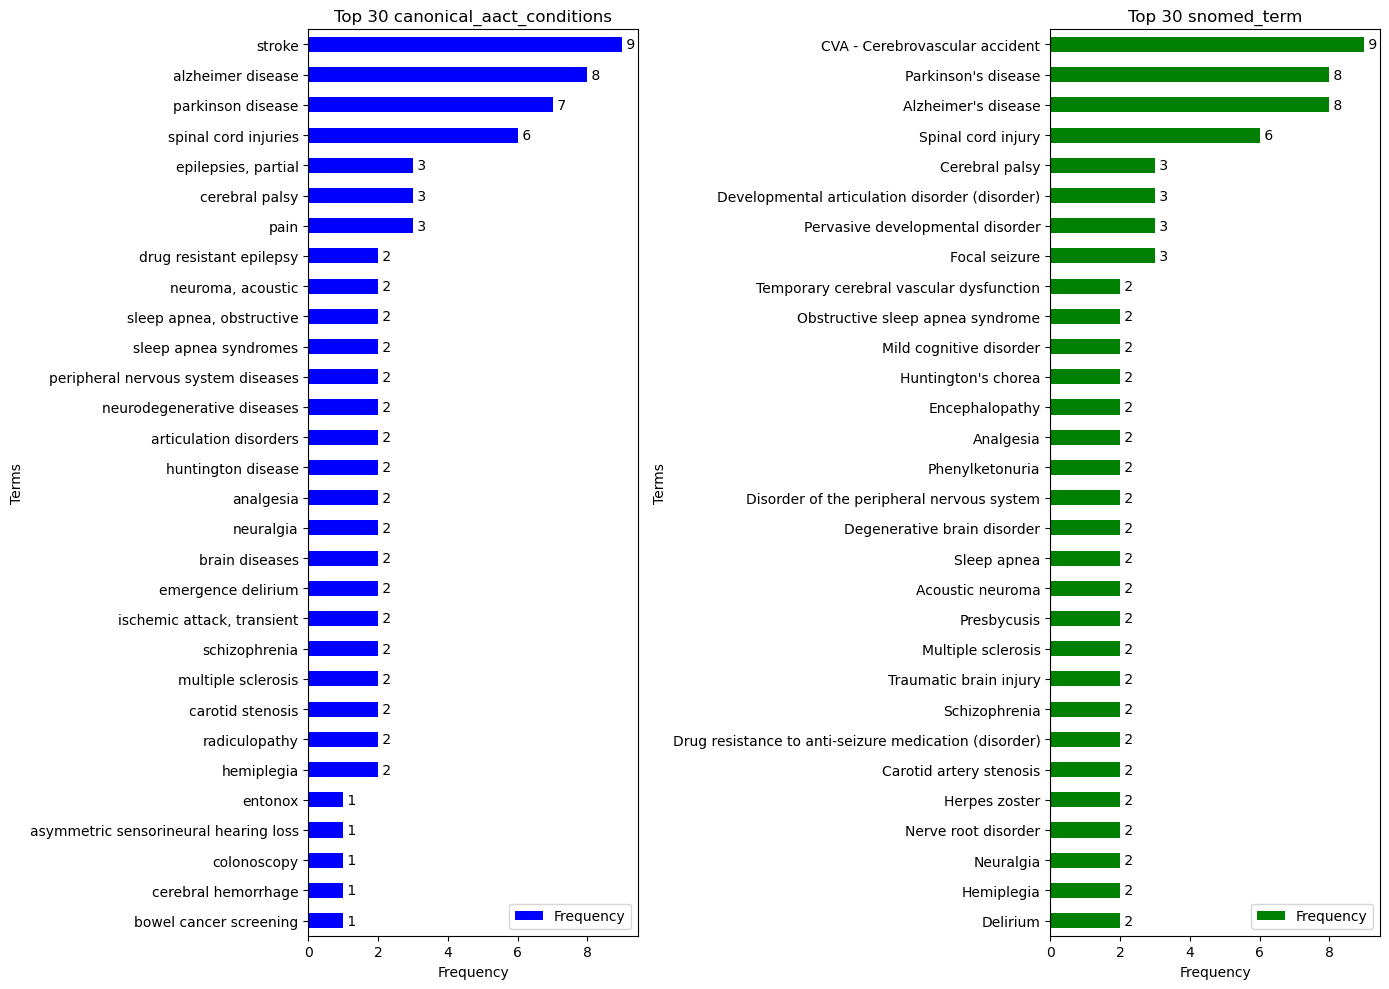

In [73]:
def count_terms(column):
    """ Utility function to count terms in a DataFrame column where terms are separated by '|' """
    term_list = []
    for item in df[column]:
        if pd.isna(item) or not isinstance(item, str):
            continue
        term_list.extend(item.split('|'))
    return Counter(term_list)

# Count terms for both columns
aact_counts = count_terms('canonical_aact_conditions')
snomed_counts = count_terms('snomed_term_norm')

# Convert counts to DataFrame for easier plotting
aact_df = pd.DataFrame(list(aact_counts.items()), columns=['Term', 'Frequency']).sort_values(by='Frequency', ascending=False).head(30)
snomed_df = pd.DataFrame(list(snomed_counts.items()), columns=['Term', 'Frequency']).sort_values(by='Frequency', ascending=False).head(30)

# Plotting with terms on the y-axis and displaying values on the bars
fig, ax = plt.subplots(1, 2, figsize=(14, 10), sharex=True)
aact_plot = aact_df.plot.barh(x='Term', y='Frequency', ax=ax[0], color='blue', title='Top 30 canonical_aact_conditions')
snomed_plot = snomed_df.plot.barh(x='Term', y='Frequency', ax=ax[1], color='green', title='Top 30 snomed_term')

# Adding text labels to the bars
for p in ax[0].patches:
    ax[0].text(p.get_width(), p.get_y() + p.get_height() / 2, ' %d' % int(p.get_width()), va='center')
for p in ax[1].patches:
    ax[1].text(p.get_width(), p.get_y() + p.get_height() / 2, ' %d' % int(p.get_width()), va='center')

ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Terms')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Terms')
ax[0].invert_yaxis()  # Invert y-axis to have the highest frequency at the top
ax[1].invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.tight_layout()
plt.show()

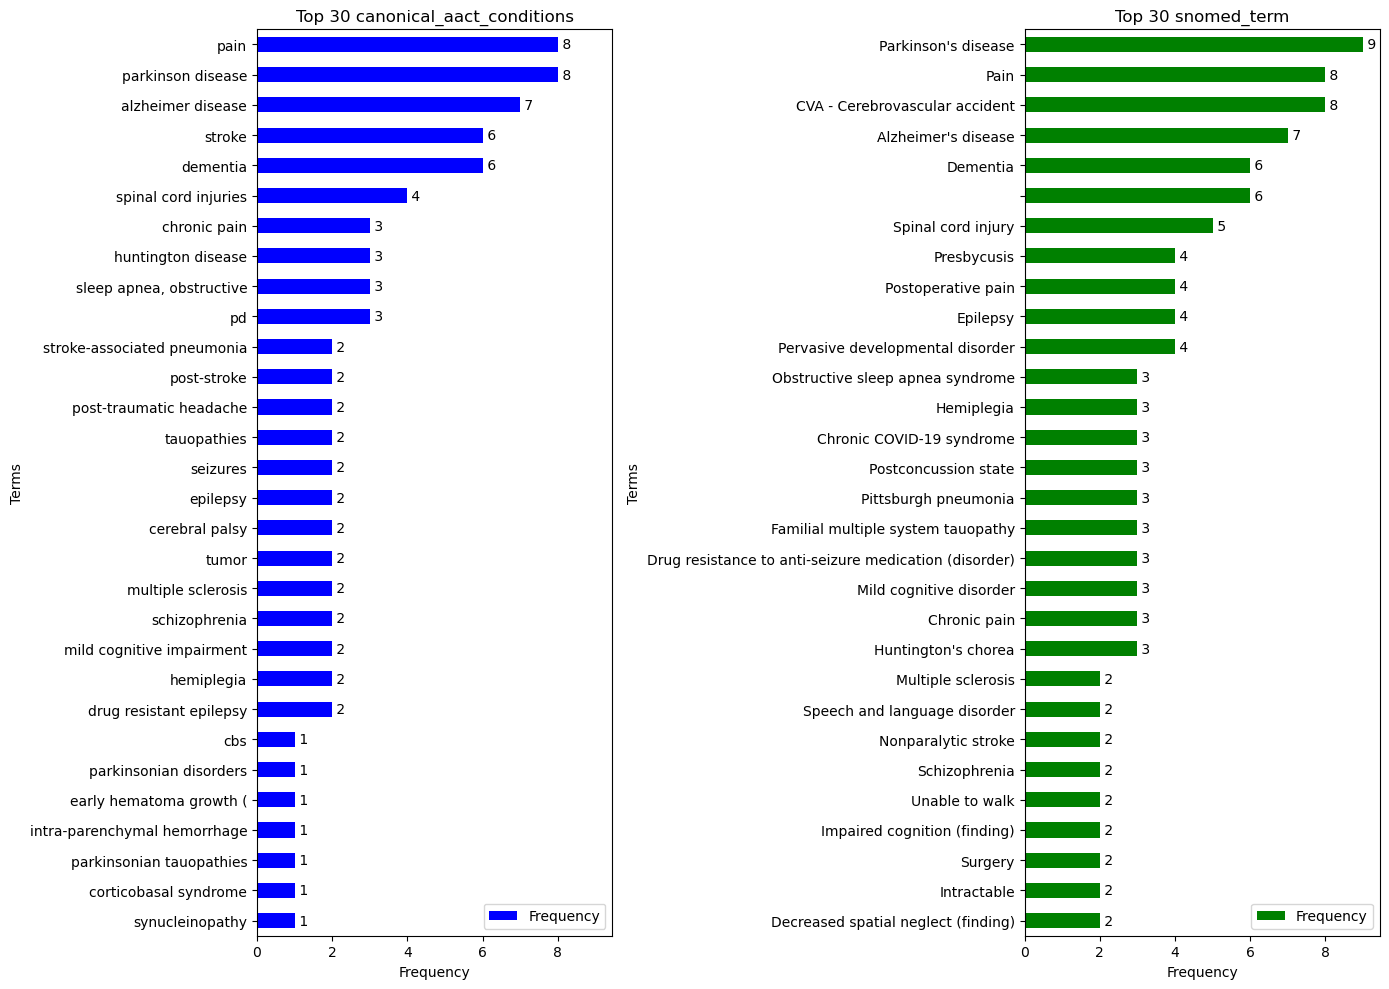

In [79]:
# Count terms for both columns
aact_counts = count_terms('canonical_BioLinkBERT-base_conditions')
snomed_counts = count_terms('linkbert_snomed_term_norm')

# Convert counts to DataFrame for easier plotting
aact_df = pd.DataFrame(list(aact_counts.items()), columns=['Term', 'Frequency']).sort_values(by='Frequency', ascending=False).head(30)
snomed_df = pd.DataFrame(list(snomed_counts.items()), columns=['Term', 'Frequency']).sort_values(by='Frequency', ascending=False).head(30)

# Plotting with terms on the y-axis and displaying values on the bars
fig, ax = plt.subplots(1, 2, figsize=(14, 10), sharex=True)
aact_plot = aact_df.plot.barh(x='Term', y='Frequency', ax=ax[0], color='blue', title='Top 30 canonical_BioLinkBERT')
snomed_plot = snomed_df.plot.barh(x='Term', y='Frequency', ax=ax[1], color='green', title='Top 30 snomed_term')

# Adding text labels to the bars
for p in ax[0].patches:
    ax[0].text(p.get_width(), p.get_y() + p.get_height() / 2, ' %d' % int(p.get_width()), va='center')
for p in ax[1].patches:
    ax[1].text(p.get_width(), p.get_y() + p.get_height() / 2, ' %d' % int(p.get_width()), va='center')

ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Terms')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Terms')
ax[0].invert_yaxis()  # Invert y-axis to have the highest frequency at the top
ax[1].invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.tight_layout()
plt.show()

In [95]:
combined_term_to_norm['early hematoma growth (']

'Early neonatal cerebral haematoma'

In [98]:
combined_norm_to_term

{"Alexander's disease": ['alexander disease'],
 'Pain': ['pain'],
 'Chronic pain': ['chronic pain'],
 'Hyperalgesia': ['hyperalgesia'],
 'Pervasive developmental disorder': ['autism spectrum disorder',
  'autism spectrum disorders'],
 'Lumbosacral nerve root pain': ['lumbosacral radicular pain'],
 'Lumbosacral root lesion': ['lumbosacral radiculopathy'],
 'Traumatic brain injury': ['acquired brain injury'],
 'Gait abnormality': ['gait impairment'],
 'Spinal cord injury': ['spinal cord injuries'],
 'Brain concussion': ['mild traumatic brain injury'],
 'Mild cognitive disorder': ['mild cognitive impairment'],
 'Glioblastoma multiforme of brain': ['recurrent glioblastoma multiforme'],
 'CVA - Cerebrovascular accident': ['stroke'],
 'Obstructive sleep apnea syndrome': ['sleep apnea, obstructive'],
 'Postconcussion state': ['poststroke'],
 'Autosomal recessive spastic paraplegia type 26 (disorder)': ['marrow-sea deficiency'],
 'Vascular dementia (disorder)': ['dementia, vascular'],
 'Disrup

In [96]:
combined_term_to_norm

{'alexander disease': "Alexander's disease",
 'pain': 'Pain',
 'chronic pain': 'Chronic pain',
 'hyperalgesia': 'Hyperalgesia',
 'autistic disorder': 'Pervasive developmental disorder',
 'pervasive developmental disorders': 'Pervasive developmental disorder',
 'lumbosacral radicular pain': 'Lumbosacral nerve root pain',
 'lumbosacral radiculopathy': 'Lumbosacral root lesion',
 'acquired brain injury': 'Traumatic brain injury',
 'gait impairment': 'Gait abnormality',
 'spinal cord injuries': 'Spinal cord injury',
 'concussion': 'Brain concussion',
 'mild cognitive impairment': 'Mild cognitive disorder',
 'recurrent glioblastoma multiforme': 'Glioblastoma multiforme of brain',
 'stroke': 'CVA - Cerebrovascular accident',
 'sleep apnea, obstructive': 'Obstructive sleep apnea syndrome',
 'post-stroke': 'Postconcussion state',
 'marrow-sea deficiency': 'Autosomal recessive spastic paraplegia type 26 (disorder)',
 'dementia, vascular': 'Vascular dementia (disorder)',
 'autism spectrum disord

In [83]:
term_to_norm_linkbert

0      
1      
2      
3    {}
4    {}
dtype: object

# Testing of Functionalities

In [15]:
query = "multiple sclerosis"
query_toks = tokenizer.batch_encode_plus([query], 
                                       padding="max_length", 
                                       max_length=25, 
                                       truncation=True,
                                       return_tensors="pt")
query_output = model(**query_toks)
query_cls_rep = query_output[0][:,0,:]
dist = cdist(query_cls_rep.cpu().detach().numpy(), all_reps_emb_full)
nn_index = np.argmin(dist)
print ("predicted label:", snomed_sf_id_pairs[nn_index])


predicted label: ('Multiple sclerosis', '24700007')


In [16]:
nn_indices = np.argsort(dist[0])[:3]  # Get indices of three smallest distances

print("Top 3 predicted labels:")
for idx in nn_indices:
    print(snomed_sf_id_pairs[idx])

Top 3 predicted labels:
('Multiple sclerosis', '24700007')
('Multiple sclerosis (disorder)', '24700007')
('MS - Multiple sclerosis', '24700007')


In [17]:
snomed['24700007']

{'desc': 'Multiple sclerosis'}

In [126]:
query = "multiple sclerosis, relapsing-remitting"
query_toks = tokenizer.batch_encode_plus([query], 
                                       padding="max_length", 
                                       max_length=25, 
                                       truncation=True,
                                       return_tensors="pt")
query_output = model(**query_toks)
query_cls_rep = query_output[0][:,0,:]
dist = cdist(query_cls_rep.cpu().detach().numpy(), all_reps_emb_full)
nn_index = np.argmin(dist)
print ("predicted label:", snomed_sf_id_pairs[nn_index])

predicted label: ('Relapsing remitting multiple sclerosis', '426373005')


In [127]:
nn_indices = np.argsort(dist[0])[:3]  # Get indices of three smallest distances

print("Top 3 predicted labels:")
for idx in nn_indices:
    print(snomed_sf_id_pairs[idx])

Top 3 predicted labels:
('Relapsing remitting multiple sclerosis', '426373005')
('Relapsing remitting multiple sclerosis (disorder)', '426373005')
('Multiple sclerosis (MS) relapsing remitting', '426373005')


#### anorexia variations

#### encode query

In [112]:
query = "anorexic"
query_toks = tokenizer.batch_encode_plus([query], 
                                       padding="max_length", 
                                       max_length=25, 
                                       truncation=True,
                                       return_tensors="pt")


predicted label: ('Depression', '35489007')


Top 3 predicted labels:
('Depressive symptoms', '394924000')
('Depressive illness', '35489007')
('Depressive disorder', '35489007')


In [95]:
snomed['394924000']

{'desc': 'Symptoms of depression (finding)'}

#### find query nearest neighbour

In [101]:
dist = cdist(query_cls_rep.cpu().detach().numpy(), all_reps_emb_full)
nn_index = np.argmin(dist)
print ("predicted label:", snomed_sf_id_pairs[nn_index])

predicted label: ('Anorexic', '79890006')


In [102]:
snomed['79890006'], snomed.predecessors('79890006')

({'desc': 'Loss of appetite'}, ['289162002'])

In [103]:
snomed['405788002'], snomed.predecessors('405788002')

({'desc': 'Psychogenic loss of appetite'}, ['79890006', '72366004'])

In [104]:
snomed['72366004'], snomed.predecessors('72366004')

({'desc': 'Eating disorder'}, ['231520001'])

In [95]:
snomed['231520001'], snomed.predecessors('231520001')

({'desc': 'Behavioural syndrome associated with physiological disturbance and physical factors'},
 ['74732009'])

In [96]:
snomed['74732009'], snomed.predecessors('74732009')

({'desc': 'Mental disorder'}, ['64572001'])

In [97]:
snomed['64572001'], snomed.predecessors('64572001')

({'desc': 'Disease'}, ['404684003'])

In [160]:
snomed['289162002'], snomed.predecessors('289162002'), snomed['289161009'], snomed.predecessors('289161009')

({'desc': 'Finding of quantity of appetite'},
 ['289161009'],
 {'desc': 'Finding of appetite'},
 ['116336009', '118228005'])

In [161]:
snomed['118228005'], snomed.predecessors('118228005'), snomed['404684003'], snomed.predecessors('404684003'), snomed['138875005'], snomed.predecessors('138875005')

({'desc': 'Functional finding'},
 ['404684003'],
 {'desc': 'Clinical finding (finding)'},
 ['138875005'],
 {'desc': 'SNOMED CT Concept'},
 [])

In [90]:
snomed['116336009'], snomed.predecessors('116336009')

({'desc': 'Eating feeding and drinking observations'}, ['404684003'])

In [93]:
snomed['404684003'], snomed.predecessors('404684003')

({'desc': 'Clinical finding (finding)'}, ['138875005'])

#### schizophrenia variations
- schizophrenia: predicted label: ('Schizophrenia', '58214004')
- schizophrenic: predicted label: ('Schizophrenic disorders', '191526005'), predecessors: 58214004
- first-episode schizophrenia: predicted label: ('Early onset schizophrenia', '1204417003'), predecessors: ['58214004', '118940003']
- chronic schizophrenia: predicted label: ('Chronic schizophrenia', '83746006')

In [124]:
query = "chronic schizophrenia"
query_toks = tokenizer.batch_encode_plus([query], 
                                       padding="max_length", 
                                       max_length=25, 
                                       truncation=True,
                                       return_tensors="pt")
query_output = model(**query_toks)
query_cls_rep = query_output[0][:,0,:]
dist = cdist(query_cls_rep.cpu().detach().numpy(), all_reps_emb_full)
nn_index = np.argmin(dist)
print ("predicted label:", snomed_sf_id_pairs[nn_index])

predicted label: ('Chronic schizophrenia', '83746006')


In [125]:
snomed['83746006'], snomed.predecessors('83746006'), snomed.successors('83746006')

({'desc': 'Chronic schizophrenia'},
 ['128293007', '58214004'],
 ['12939007', '29599000', '31658008', '68995007', '71103003', '191531007'])

In [117]:
snomed['1204417003'], snomed.predecessors('1204417003'), snomed.successors('1204417003')

({'desc': 'Early onset schizophrenia'}, ['58214004', '118940003'], [])

In [108]:
snomed['58214004'], snomed.predecessors('58214004'), snomed.successors('58214004')

({'desc': 'Schizophrenia'},
 ['69322001'],
 ['191527001',
  '191542003',
  '111484002',
  '268617001',
  '26025008',
  '26472000',
  '35252006',
  '64905009',
  '83746006',
  '191526005',
  '191577003',
  '247804008',
  '416340002',
  '4926007',
  '1204417003'])

In [128]:
snomed['128293007'], snomed.predecessors('128293007'), snomed['27624003'], snomed.predecessors('27624003'), snomed['74732009'], snomed.predecessors('74732009')

({'desc': 'Chronic mental illness'},
 ['27624003', '74732009'],
 {'desc': 'Chronic disease'},
 ['64572001'],
 {'desc': 'Mental disorder'},
 ['64572001'])

In [122]:
 snomed['118940003'], snomed.predecessors('118940003'), snomed['362965005'], snomed.predecessors('362965005'),  snomed['64572001'], snomed.predecessors('64572001')

({'desc': 'Neurological disorder'},
 ['362965005'],
 {'desc': 'Disorder of body system'},
 ['64572001'],
 {'desc': 'Disease'},
 ['404684003'])

In [123]:
 snomed['69322001'], snomed.predecessors('69322001'), snomed['74732009'], snomed.predecessors('74732009'), snomed['64572001'], snomed.predecessors('64572001')

({'desc': 'Psychotic disorder'},
 ['74732009'],
 {'desc': 'Mental disorder'},
 ['64572001'],
 {'desc': 'Disease'},
 ['404684003'])

In [34]:
snomed['404684003'], snomed.predecessors('404684003')

({'desc': 'Clinical finding (finding)'}, ['138875005'])

In [35]:
snomed['138875005'], snomed.predecessors('138875005')

({'desc': 'SNOMED CT Concept'}, [])

#### bipolar variations
- 'bipolar',
- 'bipolar 1 disorder',
- 'bipolar disorder',
- 'bipolar disorder i',
- 'bipolar hypomania',
- 'bipolar i',
- 'bipolar i disorder',
- 'bipolar i or ii disorder',
- 'bipolar ii disorder',
- 'bipolar mania',
- 'bipolar or schizoaffective disorder',
- 'bipolar spectrum disorder',
- 'bipolar spectrum disorders',
- 'bipolar spectrum or',

In [131]:
def map_to_snomed(query):
    query_toks = tokenizer.batch_encode_plus([query], 
                                       padding="max_length", 
                                       max_length=25, 
                                       truncation=True,
                                       return_tensors="pt")
    query_output = model(**query_toks)
    query_cls_rep = query_output[0][:,0,:]
    dist = cdist(query_cls_rep.cpu().detach().numpy(), all_reps_emb_full)
    nn_index = np.argmin(dist)
    print ("predicted label:", snomed_sf_id_pairs[nn_index])

In [163]:
map_to_snomed('rgbm'), snomed.predecessors('260994008')

predicted label: ('RGM', '116494006')


(None, ['277425009'])

In [142]:
map_to_snomed('bipolar'), snomed.predecessors('260994008')

predicted label: ('Bipolar', '260994008')


(None, ['277425009'])

In [147]:
snomed['260994008'], snomed.predecessors('260994008'), snomed['277425009'], snomed.predecessors('277425009'),  snomed['255277001'], snomed.predecessors('255277001'),  snomed['272099008'], snomed.predecessors('272099008')

({'desc': 'Bipolar'},
 ['277425009'],
 {'desc': 'Polar formations'},
 ['255277001'],
 {'desc': 'Formations'},
 ['272099008'],
 {'desc': 'Descriptor (qualifier value)'},
 ['362981000'])

In [141]:
map_to_snomed('bipolar spectrum disorders')

predicted label: ('Bipolar disorder', '13746004')


In [133]:
map_to_snomed('bipolar 1 disorder')

predicted label: ('Bipolar 1 disorder', '371596008')


In [134]:
map_to_snomed('bipolar i disorder')

predicted label: ('Bipolar I disorder', '371596008')


In [135]:
map_to_snomed('bipolar i')

predicted label: ('Bipolar I disorder', '371596008')


In [136]:
map_to_snomed('bipolar ii disorder')

predicted label: ('Bipolar II disorder', '83225003')


In [137]:
map_to_snomed('bipolar hypomania')

predicted label: ('Hypomanic mood', '281257007')


In [138]:
map_to_snomed('bipolar mania')

predicted label: ('Manic bipolar I disorder (disorder)', '68569003')


cognitive impairment

In [154]:
map_to_snomed('cognitive impairment'), map_to_snomed('cognitive dysfunction'), map_to_snomed('cognitive deficit')

predicted label: ('Cognitive impairment', '386806002')
predicted label: ('Cognitive dysfunction', '386806002')
predicted label: ('Cognitive deficit', '386806002')


(None, None, None)

In [155]:
snomed['386806002']

{'desc': 'Impaired cognition (finding)'}

#### Tests for Drugs

In [ ]:
map_to_snomed('pimavanserin')


In [159]:
snomed['721997002'], snomed.predecessors('721997002'), snomed['372521009'], snomed.predecessors('372521009'), snomed['412053006'], snomed.predecessors('412053006')

({'desc': 'Pimavanserin (substance)'},
 ['372521009', '412053006', '372482001'],
 {'desc': 'Piperidine derivative (substance)'},
 ['123682001'],
 {'desc': 'Urea and/or urea derivative'},
 ['41175001'])

# Mapping of Full Linked Data to Top Concept Node

In [696]:
snomed_node_hierarchies = pd.read_csv("data/snomed/snomed_node_hierarchies.csv")[['Node', 'Parents', 'Parents_Desc', 'Children', 'Children_Desc']]
snomed_node_hierarchies.head()

,Node,Parents,Parents_Desc,Children,Children_Desc
0,10000006,"[302292003, 404684003, 9972008, 298705000, 222...","['Finding of trunk structure', 'Clinical findi...",[],[]
1,29857009,"[302292003, 404684003, 298705000, 22253000, 10...","['Finding of trunk structure', 'Clinical findi...","[279019008, 83264000, 279038004, 1264062004, 3...","['Central crushing chest pain', 'Epidemic pleu..."
2,9972008,"[404684003, 22253000, 102957003, 106147001, 13...","['Clinical finding (finding)', 'Pain', 'Neurol...","[10000006, 427653003, 427365005, 426469008, 12...","['Radiating chest pain', 'Pain radiating to ri..."
3,134035007,"[421371008, 312779009, 69536005, 47173002, 281...","['Structure of lateral half of head', 'Bone st...",[],[]
4,84371003,"[421371008, 312779009, 69536005, 47173002, 281...","['Structure of lateral half of head', 'Bone st...",[134035007],['Entire stylomastoid foramen']


In [697]:
model = 'linkbert'
if model  == 'linkbert':
    ner_output_col = 'canonical_BioLinkBERT-base_conditions'
else:
    ner_output_col = 'canonical_aact_conditions'
df_cond = pd.read_csv("data/annotated_aact/sapbert_normalized_annotations_linkbert_19607.csv")[['nct_id', ner_output_col, f'{model}_snomed_termid',	f'{model}_snomed_term_norm']]
df_cond.head()

,nct_id,canonical_BioLinkBERT-base_conditions,linkbert_snomed_termid,linkbert_snomed_term_norm
0,NCT00000117,multiple sclerosis|optic neuritis,24700007|66760008,Multiple sclerosis|Optic neuritis
1,NCT00000146,multiple sclerosis|optic neuritis,24700007|66760008,Multiple sclerosis|Optic neuritis
2,NCT00000147,multiple sclerosis|optic neuritis,24700007|66760008,Multiple sclerosis|Optic neuritis
3,NCT00000151,blindness|diabetes mellitus|diabetic retinopat...,65956007|73211009|4855003|312906006|313165001,Legal blindness|Diabetes mellitus|Diabetic ret...
4,NCT00000170,amblyopia|anisometropia|moderate amblyopia|str...,387742006|3289004|397542006|22066006,Amblyopia (disorder)|Anisometropia|Moderate vi...


In [698]:
columns_to_explode = [ner_output_col, f'{model}_snomed_termid',	f'{model}_snomed_term_norm']

for col in columns_to_explode:
    # Convert column to string, but handle None correctly
    df_cond[col] = df_cond[col].apply(lambda x: x.split('|') if pd.notnull(x) else [])
    

In [699]:
df_cond

,nct_id,canonical_BioLinkBERT-base_conditions,linkbert_snomed_termid,linkbert_snomed_term_norm
0,NCT00000117,"[multiple sclerosis, optic neuritis]","[24700007, 66760008]","[Multiple sclerosis, Optic neuritis]"
1,NCT00000146,"[multiple sclerosis, optic neuritis]","[24700007, 66760008]","[Multiple sclerosis, Optic neuritis]"
2,NCT00000147,"[multiple sclerosis, optic neuritis]","[24700007, 66760008]","[Multiple sclerosis, Optic neuritis]"
3,NCT00000151,"[blindness, diabetes mellitus, diabetic retino...","[65956007, 73211009, 4855003, 312906006, 31316...","[Legal blindness, Diabetes mellitus, Diabetic ..."
4,NCT00000170,"[amblyopia, anisometropia, moderate amblyopia,...","[387742006, 3289004, 397542006, 22066006]","[Amblyopia (disorder), Anisometropia, Moderate..."
...,...,...,...,...
19602,NCT06293911,"[down syndrome, gingival inflammation, periodo...","[41040004, 66383009, 41565005]","[Complete trisomy 21 syndrome, Gingivitis, Per..."
19603,NCT06294236,"[gleam, severe autoimmune diseases, severe rel...","[895221001, 4301008, 722290008]","[Genus Gleimia, Autoimmune state, Autoimmune l..."
19604,NCT06294821,"[carpal tunnel release, carpal tunnel syndrome...","[47534009, 57406009, 45781009]","[Decompression of median nerve, Carpal tunnel ..."
19605,NCT06296082,"[post-stroke, post-stroke spasticity, spastici...","[11764003, 108691000119102, 221360009, 230690007]","[Postconcussion state, Spasticity as sequela o..."


In [700]:
filtered_df = df_cond[df_cond['canonical_BioLinkBERT-base_conditions'].apply(len) != df_cond['linkbert_snomed_termid'].apply(len)]
filtered_df

,nct_id,canonical_BioLinkBERT-base_conditions,linkbert_snomed_termid,linkbert_snomed_term_norm
13,NCT00000179,"[ad, agitation]",[24199005],[Agitation]
25,NCT00000210,"[aids, concurrent intravenous heroin and cocai...","[1255012001, 91388009]","[Combined substance dependence, continuous, Ps..."
26,NCT00000211,"[aids, concurrent intravenous heroin and cocai...","[1255012001, 91388009]","[Combined substance dependence, continuous, Ps..."
101,NCT00000321,"[aids, methamphetamine, methamphetamine depend...","[387499002, 426873000]","[Methamphetamine, Methamphetamine dependence (..."
125,NCT00000368,"[agoraphobia, panic disorder, pd]","[70691001, 371631005]","[Agoraphobia, Panic disorder (disorder)]"
...,...,...,...,...
19571,NCT06276504,"[hiv, hiv infection, immunocompromised, jcv, l...","[86406008, 370388006, 22255007, 22255007]","[Human immunodeficiency virus infection, Patie..."
19574,NCT06279858,"[fragile x, fragile x syndrome, fxs]","[205720009, 613003]","[Fragile X chromosome, Fragile X syndrome]"
19581,NCT06282640,"[carpal tunnel syndrome, cts, pain]","[57406009, 22253000]","[Carpal tunnel syndrome, Pain]"
19584,NCT06285006,"[mne, monosymptomatic nocturnal enuresis, nmne...","[450845009, 8009008]","[Primary nocturnal enuresis, Bed wetting]"


In [701]:
df_cond_filtered = df_cond[df_cond['canonical_BioLinkBERT-base_conditions'].apply(len) == df_cond['linkbert_snomed_termid'].apply(len)]
df_cond_filtered.shape


(17300, 4)

In [702]:
df_non_standard_types = df_cond[df_cond.applymap(lambda x: not isinstance(x, (int, float, str, tuple, list))).any(axis=1)]
df_non_standard_types

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_98515/4039978171.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_non_standard_types = df_cond[df_cond.applymap(lambda x: not isinstance(x, (int, float, str, tuple, list))).any(axis=1)]


,nct_id,canonical_BioLinkBERT-base_conditions,linkbert_snomed_termid,linkbert_snomed_term_norm


In [703]:
df_exploded_cond = df_cond_filtered.explode(columns_to_explode).reset_index(drop=True)
df_exploded_cond.head()

,nct_id,canonical_BioLinkBERT-base_conditions,linkbert_snomed_termid,linkbert_snomed_term_norm
0,NCT00000117,multiple sclerosis,24700007,Multiple sclerosis
1,NCT00000117,optic neuritis,66760008,Optic neuritis
2,NCT00000146,multiple sclerosis,24700007,Multiple sclerosis
3,NCT00000146,optic neuritis,66760008,Optic neuritis
4,NCT00000147,multiple sclerosis,24700007,Multiple sclerosis


In [704]:
df_exploded_cond = df_exploded_cond.dropna()


In [705]:
len(set(df_exploded_cond['nct_id']))

15993

In [706]:
# If your IDs are stored as strings or if there's a type mismatch, explicitly convert them
df_exploded_cond[f'{model}_snomed_termid'] = df_exploded_cond[f'{model}_snomed_termid'].astype(int)
snomed_node_hierarchies['Node'] = snomed_node_hierarchies['Node'].astype(int)

condition_hierarchies =  pd.merge(df_exploded_cond, snomed_node_hierarchies, left_on=f'{model}_snomed_termid', right_on='Node', how='left')

# Assuming 'Node' is a single integer value column and 'Parents' is a list of integers
condition_hierarchies['Node'] = condition_hierarchies['Node'].astype(int)

# For 'Parents', if it's a list of numbers stored as strings, you'll need to convert each element in the list individually
condition_hierarchies['Parents'] = condition_hierarchies['Parents'].apply(
    lambda x: [int(i) for i in ast.literal_eval(x)] if x and x != '[]' else []
)
condition_hierarchies.head()

,nct_id,canonical_BioLinkBERT-base_conditions,linkbert_snomed_termid,linkbert_snomed_term_norm,Node,Parents,Parents_Desc,Children,Children_Desc
0,NCT00000117,multiple sclerosis,24700007,Multiple sclerosis,24700007,"[362975008, 64572001, 363171009, 404684003, 11...","['Degenerative disorder', 'Disease', 'Inflamma...","[192927008, 733028000, 816984002, 230372003, 1...","['Multiple sclerosis of the spinal cord', 'Mul..."
1,NCT00000117,optic neuritis,66760008,Optic neuritis,66760008,"[73013002, 77157004, 362965005, 21018002, 5476...","['Cranial nerve disorder', 'Disorder of optic ...","[230507009, 1169360001, 866133000, 73221001, 5...","['RBN - Retrobulbar neuritis', 'Chronic relaps..."
2,NCT00000146,multiple sclerosis,24700007,Multiple sclerosis,24700007,"[362975008, 64572001, 363171009, 404684003, 11...","['Degenerative disorder', 'Disease', 'Inflamma...","[192927008, 733028000, 816984002, 230372003, 1...","['Multiple sclerosis of the spinal cord', 'Mul..."
3,NCT00000146,optic neuritis,66760008,Optic neuritis,66760008,"[73013002, 77157004, 362965005, 21018002, 5476...","['Cranial nerve disorder', 'Disorder of optic ...","[230507009, 1169360001, 866133000, 73221001, 5...","['RBN - Retrobulbar neuritis', 'Chronic relaps..."
4,NCT00000147,multiple sclerosis,24700007,Multiple sclerosis,24700007,"[362975008, 64572001, 363171009, 404684003, 11...","['Degenerative disorder', 'Disease', 'Inflamma...","[192927008, 733028000, 816984002, 230372003, 1...","['Multiple sclerosis of the spinal cord', 'Mul..."


In [719]:
# Convert Node column to set for faster lookup Encephalomyeloneuropathy	23853001
node_set = set(condition_hierarchies['Node']) - {410942007, 844005, 129104009, 700364009, 5294002, 57697001, 107669003, 49755003, 105590001, 71388002, 65971000052100,128283000,301766008,70835005,399317006, 60342002, 1821000146108, 91388009, 441527004, 275471001, 26416006, 442406005, 128293007, 46206005, 27624003, 2704003, 85828009, 66214007, 1254812006, 75934005, 52448006, 52522001, 64572001, 404684003, 74732009, 69322001, 138875005, 118940003, 128139000, 23853001, 363171009, 6118003, 39367000, 42658009, 106030000, 106030000, 106028002, 928000, 129565002, 14817008, 417163006, 49601007, 81308009, 386806002} 
# exclude very generic nodes here? like ['Disease', 'Clinical finding (finding)', 'Mental disorder', 'Psychotic disorder', 'SNOMED CT Concept', 'Neurological disorder', 'Inflammatory disroder', 'Encephalomyeloneuropathy' ] = [64572001, 404684003, 74732009, 69322001, 138875005]

# Filter Descendants based on whether they appear in the Node column
condition_hierarchies['Filtered_Parents'] = condition_hierarchies['Parents'].apply(lambda x: [item for item in x if item in node_set])

main_parent_nodes = condition_hierarchies[condition_hierarchies['Filtered_Parents'].apply(lambda x: len(x) == 0)]['Node']
main_parent_nodes_set = set(main_parent_nodes) - {64572001} # EXCLUDE THE GENERIC 'Disease' Parent

condition_hierarchies['Top_Concept'] = condition_hierarchies['Filtered_Parents'].apply(
    lambda x: [node for node in x if node in main_parent_nodes_set] if len(x) > 1 else x # AND x should not be the generic Disease
)

condition_hierarchies['Top_Concept_Desc'] = condition_hierarchies['Top_Concept'].apply(lambda ids: [get_description(snomed, id) for id in ids])

condition_hierarchies.head()

,nct_id,canonical_BioLinkBERT-base_conditions,linkbert_snomed_termid,linkbert_snomed_term_norm,Node,Parents,Parents_Desc,Children,Children_Desc,Filtered_Parents,Top_Concept,Top_Concept_Desc
0,NCT00000117,multiple sclerosis,24700007,Multiple sclerosis,24700007,"[362975008, 64572001, 363171009, 404684003, 11...","['Degenerative disorder', 'Disease', 'Inflamma...","[192927008, 733028000, 816984002, 230372003, 1...","['Multiple sclerosis of the spinal cord', 'Mul...",[],[],[]
1,NCT00000117,optic neuritis,66760008,Optic neuritis,66760008,"[73013002, 77157004, 362965005, 21018002, 5476...","['Cranial nerve disorder', 'Disorder of optic ...","[230507009, 1169360001, 866133000, 73221001, 5...","['RBN - Retrobulbar neuritis', 'Chronic relaps...","[73013002, 77157004, 21018002, 386033004]",[386033004],[Neuropathy (disorder)]
2,NCT00000146,multiple sclerosis,24700007,Multiple sclerosis,24700007,"[362975008, 64572001, 363171009, 404684003, 11...","['Degenerative disorder', 'Disease', 'Inflamma...","[192927008, 733028000, 816984002, 230372003, 1...","['Multiple sclerosis of the spinal cord', 'Mul...",[],[],[]
3,NCT00000146,optic neuritis,66760008,Optic neuritis,66760008,"[73013002, 77157004, 362965005, 21018002, 5476...","['Cranial nerve disorder', 'Disorder of optic ...","[230507009, 1169360001, 866133000, 73221001, 5...","['RBN - Retrobulbar neuritis', 'Chronic relaps...","[73013002, 77157004, 21018002, 386033004]",[386033004],[Neuropathy (disorder)]
4,NCT00000147,multiple sclerosis,24700007,Multiple sclerosis,24700007,"[362975008, 64572001, 363171009, 404684003, 11...","['Degenerative disorder', 'Disease', 'Inflamma...","[192927008, 733028000, 816984002, 230372003, 1...","['Multiple sclerosis of the spinal cord', 'Mul...",[],[],[]


In [710]:
condition_hierarchies[condition_hierarchies['linkbert_snomed_term_norm'].str.contains('Stroke', na=False)]


,nct_id,canonical_BioLinkBERT-base_conditions,linkbert_snomed_termid,linkbert_snomed_term_norm,Node,Parents,Parents_Desc,Children,Children_Desc,Filtered_Parents,Top_Concept
590,NCT00004727,antiplatelet stroke,135875009,Stroke prevention,135875009,"[169443000, 362961001, 71388002, 138875005]","['Preventive procedure', 'Procedure by intent'...",[],[],[],[]
2472,NCT00129805,secondary prevention of cerebral infarction,135875009,Stroke prevention,135875009,"[169443000, 362961001, 71388002, 138875005]","['Preventive procedure', 'Procedure by intent'...",[],[],[],[]
11149,NCT00781326,cerebrovascular risk,135877001,Stroke risk,135877001,"[254291000, 138875005, 273249006]","['Staging and scales', 'SNOMED CT Concept', 'A...","[438367009, 713678009]","['Congestive heart failure, hypertension, age ...",[],[]
22586,NCT02239120,embolic stroke of undetermined source,230713003,Stroke of uncertain pathology,230713003,"[127296001, 362965005, 406122000, 82271004, 10...","['Intracranial injury', 'Disorder of body syst...","[230714009, 230715005]",['Anterior circulation stroke of uncertain pat...,"[82271004, 128239009, 127294003, 128126004, 62...","[82271004, 128239009, 62914000]"
23104,NCT02313909,embolic stroke of undetermined source,230713003,Stroke of uncertain pathology,230713003,"[127296001, 362965005, 406122000, 82271004, 10...","['Intracranial injury', 'Disorder of body syst...","[230714009, 230715005]",['Anterior circulation stroke of uncertain pat...,"[82271004, 128239009, 127294003, 128126004, 62...","[82271004, 128239009, 62914000]"
39765,NCT05559398,acute ischemic stroke therapy,135875009,Stroke prevention,135875009,"[169443000, 362961001, 71388002, 138875005]","['Preventive procedure', 'Procedure by intent'...",[],[],[],[]
41550,NCT05995600,aps-stroke,736709006,Postural Assessment Scale for Stroke Patients ...,736709006,"[254291000, 138875005, 273249006]","['Staging and scales', 'SNOMED CT Concept', 'A...",[],[],[],[]


106028002: Musculoskeletal finding	
106030000: Muscle observation	
267078001: Involuntary movement	
386806002: Impaired cognition (finding)	

In [712]:
condition_hierarchies[condition_hierarchies['Node']==62914000] # 22253000: pain, 48694002: anxiety

,nct_id,canonical_BioLinkBERT-base_conditions,linkbert_snomed_termid,linkbert_snomed_term_norm,Node,Parents,Parents_Desc,Children,Children_Desc,Filtered_Parents,Top_Concept
3135,NCT00165737,cerebrovascular disorders,62914000,Cerebrovascular disease,62914000,"[64572001, 404684003, 362965005, 49601007, 138...","['Disease', 'Clinical finding (finding)', 'Dis...","[1269248000, 16024151000119105, 32943100011910...",['Cerebrovascular accident due to occlusion of...,[],[]
3981,NCT00208611,cerebrovascular disorders,62914000,Cerebrovascular disease,62914000,"[64572001, 404684003, 362965005, 49601007, 138...","['Disease', 'Clinical finding (finding)', 'Dis...","[1269248000, 16024151000119105, 32943100011910...",['Cerebrovascular accident due to occlusion of...,[],[]
5219,NCT00261573,cerebrovascular disorders,62914000,Cerebrovascular disease,62914000,"[64572001, 404684003, 362965005, 49601007, 138...","['Disease', 'Clinical finding (finding)', 'Dis...","[1269248000, 16024151000119105, 32943100011910...",['Cerebrovascular accident due to occlusion of...,[],[]
5908,NCT00313716,cerebral vascular dysfunction,62914000,Cerebrovascular disease,62914000,"[64572001, 404684003, 362965005, 49601007, 138...","['Disease', 'Clinical finding (finding)', 'Dis...","[1269248000, 16024151000119105, 32943100011910...",['Cerebrovascular accident due to occlusion of...,[],[]
7018,NCT00402480,cerebrovascular disorders,62914000,Cerebrovascular disease,62914000,"[64572001, 404684003, 362965005, 49601007, 138...","['Disease', 'Clinical finding (finding)', 'Dis...","[1269248000, 16024151000119105, 32943100011910...",['Cerebrovascular accident due to occlusion of...,[],[]
12841,NCT00962988,cerebrovascular disorders,62914000,Cerebrovascular disease,62914000,"[64572001, 404684003, 362965005, 49601007, 138...","['Disease', 'Clinical finding (finding)', 'Dis...","[1269248000, 16024151000119105, 32943100011910...",['Cerebrovascular accident due to occlusion of...,[],[]
14604,NCT01146132,cerebrovascular disorders,62914000,Cerebrovascular disease,62914000,"[64572001, 404684003, 362965005, 49601007, 138...","['Disease', 'Clinical finding (finding)', 'Dis...","[1269248000, 16024151000119105, 32943100011910...",['Cerebrovascular accident due to occlusion of...,[],[]
16643,NCT01419275,cerebrovascular disorders,62914000,Cerebrovascular disease,62914000,"[64572001, 404684003, 362965005, 49601007, 138...","['Disease', 'Clinical finding (finding)', 'Dis...","[1269248000, 16024151000119105, 32943100011910...",['Cerebrovascular accident due to occlusion of...,[],[]
19297,NCT01762475,cerebrovascular dysfunction,62914000,Cerebrovascular disease,62914000,"[64572001, 404684003, 362965005, 49601007, 138...","['Disease', 'Clinical finding (finding)', 'Dis...","[1269248000, 16024151000119105, 32943100011910...",['Cerebrovascular accident due to occlusion of...,[],[]
26487,NCT02838589,cerebrovascular disorders,62914000,Cerebrovascular disease,62914000,"[64572001, 404684003, 362965005, 49601007, 138...","['Disease', 'Clinical finding (finding)', 'Dis...","[1269248000, 16024151000119105, 32943100011910...",['Cerebrovascular accident due to occlusion of...,[],[]


In [713]:
condition_hierarchies_multiple_top = condition_hierarchies[condition_hierarchies['Top_Concept'].apply(lambda x: len(x) > 1)]

In [714]:
condition_hierarchies_multiple_top

,nct_id,canonical_BioLinkBERT-base_conditions,linkbert_snomed_termid,linkbert_snomed_term_norm,Node,Parents,Parents_Desc,Children,Children_Desc,Filtered_Parents,Top_Concept
7,NCT00000151,diabetes mellitus,73211009,Diabetes mellitus,73211009,"[64572001, 404684003, 20957000, 126877002, 362...","['Disease', 'Clinical finding (finding)', 'Dis...","[46635009, 870528001, 721088003, 609579009, 11...","['Diabetes mellitus type I', 'Newly diagnosed ...","[126877002, 362969004]","[126877002, 362969004]"
80,NCT00000246,rapid benzodiazepine detoxification,770571009,Benzodiazepine therapy,770571009,"[128927009, 71388002, 416608005, 1263452006, 2...","['Procedure by method', 'Procedure', 'Drug the...",[],[],"[416608005, 72641008]","[416608005, 72641008]"
94,NCT00000266,schizophrenic cocaine abusers,735750005,Psychotic disorder with schizophreniform sympt...,735750005,"[11387009, 362965005, 406122000, 762325009, 69...",['Psychoactive substance-induced organic menta...,[],[],"[1187220002, 724729003, 191447007, 191483003]","[1187220002, 191447007]"
99,NCT00000268,attention deficit disorder,35253001,"Attention deficit hyperactivity disorder, pred...",35253001,"[64572001, 404684003, 118228005, 229712006, 24...","['Disease', 'Clinical finding (finding)', 'Fun...",[698689005],"['Attention deficit hyperactivity disorder, pr...","[406506008, 54319003]","[406506008, 54319003]"
268,NCT00000389,social phobia,25501002,Social phobia,25501002,"[386808001, 64572001, 198288003, 247832004, 40...","['Phobia (finding)', 'Disease', 'Anxiety state...","[62351001, 191724005, 191725006, 191726007]","['Generalized social phobia', 'Social phobia, ...","[386808001, 198288003, 247832004, 197480006, 4...","[247832004, 48694002]"
...,...,...,...,...,...,...,...,...,...,...,...
42802,NCT06290713,"muscular dystrophy, duchenne",76670001,Duchenne muscular dystrophy,76670001,"[240048000, 928000, 66091009, 73573004, 362965...",['X-linked muscular dystrophy with abnormal dy...,[],[],"[240048000, 240046001, 363058009, 79191007, 73...","[363058009, 79191007]"
42806,NCT06293300,"brain injuries, traumatic",127295002,Traumatic brain injury,127295002,"[127296001, 362965005, 406122000, 82271004, 12...","['Intracranial injury', 'Disorder of body syst...","[230763008, 722624003, 1003584006, 870549000, ...","['Traumatic cerebral oedema', 'Focal traumatic...","[82271004, 128239009, 127294003, 128126004, 41...","[82271004, 128239009, 417746004]"
42810,NCT06293911,gingival inflammation,66383009,Gingivitis,66383009,"[362965005, 406122000, 423066003, 118938008, 8...","['Disorder of body system', 'Head finding (fin...","[707792000, 709147009, 22208002, 22240003, 234...",['Necrotizing ulcerative gingivitis (disorder)...,"[50410009, 128999004, 2556008]","[50410009, 128999004]"
42811,NCT06293911,periodontal inflammation,41565005,Periodontitis,41565005,"[362965005, 406122000, 423066003, 118938008, 8...","['Disorder of body system', 'Head finding (fin...","[1184704003, 1149440003, 716117004, 715285004,...",['Periodontitis exacerbated by hypophosphatasi...,"[50410009, 128999004, 2556008]","[50410009, 128999004]"


In [715]:
len(set(condition_hierarchies_multiple_top['nct_id']))

5210

In [720]:
condition_hierarchies.to_csv(f"data/snomed/hierarchical_mapping_to_snomed_{model}_cond.csv")
condition_hierarchies_multiple_top.to_csv(f"data/snomed/hierarchical_mapping_to_snomed_{model}_cond_multi_top.csv")

In [717]:
term_dict = condition_hierarchies.set_index(f'{model}_snomed_termid')[f'{model}_snomed_term_norm'].to_dict()

In [652]:
condition_hierarchies_to_use = condition_hierarchies[['nct_id',f'{model}_snomed_term_norm', 'Top_Concept']]

# Define the function to determine the Mapped_Term based on conditions
def get_mapped_term(row, term_dict):
    if len(row['Top_Concept']) == 1:
        # Look up the term in the dictionary if there is exactly one element
        return term_dict.get(row['Top_Concept'][0], row[f'{model}_snomed_term_norm'])  # Default to original term if not found
    else:
        # If there are more than one element or it is empty, keep the original term
        return row[f'{model}_snomed_term_norm']

# Apply the function to create the Mapped_Term column
condition_hierarchies_to_use[f'{model}_snomed_mapped_term'] = condition_hierarchies_to_use.apply(lambda row: get_mapped_term(row, term_dict), axis=1)

# Drop the 'Top_Concept' column
df_cond_mapped = condition_hierarchies_to_use.drop('Top_Concept', axis=1)

# Group by 'nct_id' and concatenate the values with "|"
df_cond_mapped = df_cond_mapped.groupby('nct_id').agg(lambda x: '|'.join(x.unique())).reset_index()
df_cond_mapped

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_98515/3579335432.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condition_hierarchies_to_use[f'{model}_snomed_mapped_term'] = condition_hierarchies_to_use.apply(lambda row: get_mapped_term(row, term_dict), axis=1)


,nct_id,linkbert_snomed_term_norm,linkbert_snomed_mapped_term
0,NCT00000117,Multiple sclerosis|Optic neuritis,Multiple sclerosis|Optic neuritis
1,NCT00000146,Multiple sclerosis|Optic neuritis,Multiple sclerosis|Optic neuritis
2,NCT00000147,Multiple sclerosis|Optic neuritis,Multiple sclerosis|Optic neuritis
3,NCT00000151,Legal blindness|Diabetes mellitus|Diabetic ret...,Visual disturbance|Diabetes mellitus|Disorder ...
4,NCT00000170,Amblyopia (disorder)|Anisometropia|Moderate vi...,Amblyopia (disorder)|Anisometropia|Visual impa...
...,...,...,...
18177,NCT06293586,Strabismus surgery,Surgical procedure (procedure)
18178,NCT06293911,Complete trisomy 21 syndrome|Gingivitis|Period...,Chromosomal disorder (disorder)|Gingivitis|Per...
18179,NCT06294236,Genus Gleimia|Autoimmune state|Autoimmune lymp...,Genus Gleimia|Autoimmune state|Autoimmune lymp...
18180,NCT06294821,Decompression of median nerve|Carpal tunnel sy...,Surgical procedure (procedure)|Neuropathy (dis...


In [653]:
df_cond = pd.read_csv(f"data/annotated_aact/sapbert_normalized_annotations_{model}_19607.csv")#[['nct_id', f'{model}_snomed_termid',	f'{model}_snomed_term_norm']]
df_cond_with_mapped = pd.merge(df_cond, df_cond_mapped[['nct_id',f'{model}_snomed_mapped_term']], how='left')
df_cond_with_mapped[f'{model}_snomed_mapped_term'] = df_cond_with_mapped[f'{model}_snomed_mapped_term'].fillna(df_cond_with_mapped[f'{model}_snomed_term_norm'])
# Drop unwanted columns
df_cond_with_mapped = df_cond_with_mapped.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)

# Save to CSV
df_cond_with_mapped.to_csv(f"data/annotated_aact/sapbert_normalized_annotations_{model}_19607_with_mapping.csv", index=False)
df_cond_with_mapped

,nct_id,canonical_BioLinkBERT-base_interventions,canonical_aact_interventions,aact_intervention_types,canonical_BioLinkBERT-base_conditions,canonical_aact_conditions,Disease Class,linkbert_snomed_term,linkbert_snomed_termid,linkbert_snomed_term_norm,linkbert_cdist,linkbert_softmax_prob,linkbert_snomed_mapped_term
0,NCT00000117,intravenous immunoglobulin|ivig,immunoglobulin,Drug,multiple sclerosis|optic neuritis,optic neuritis,Cranial Nerve Diseases,Multiple sclerosis|Optic neuritis,24700007|66760008,Multiple sclerosis|Optic neuritis,0.0|0.0,0.808|0.7814,Multiple sclerosis|Optic neuritis
1,NCT00000146,corticosteroid,methylprednisolone|prednisone,Drug,multiple sclerosis|optic neuritis,multiple sclerosis|optic neuritis,Cranial Nerve Diseases|Demyelinating Diseases,Multiple sclerosis|Optic neuritis,24700007|66760008,Multiple sclerosis|Optic neuritis,0.0|0.0,0.808|0.7814,Multiple sclerosis|Optic neuritis
2,NCT00000147,corticosteroid,methylprednisolone|prednisone,Drug,multiple sclerosis|optic neuritis,multiple sclerosis|optic neuritis,Cranial Nerve Diseases|Demyelinating Diseases,Multiple sclerosis|Optic neuritis,24700007|66760008,Multiple sclerosis|Optic neuritis,0.0|0.0,0.808|0.7814,Multiple sclerosis|Optic neuritis
3,NCT00000151,acetylsalicylic acid|aspirin,aspirin|acetylsalicylic acid,Drug|Procedure,blindness|diabetes mellitus|diabetic retinopat...,diabetic retinopathy|blindness,Neurologic Manifestations|unknown,Legal blindness|Diabetes mellitus|Diabetic ret...,65956007|73211009|4855003|312906006|313165001,Legal blindness|Diabetes mellitus|Diabetic ret...,8.1673|0.0|0.0|7.5725|7.2826,0.0335|0.8179|0.9576|0.0911|0.0707,Visual disturbance|Diabetes mellitus|Disorder ...
4,NCT00000170,atropine,atropine|,Drug|Device,amblyopia|anisometropia|moderate amblyopia|str...,amblyopia,Neurologic Manifestations,Amblyopia|Anisometropia|Moderate visual impair...,387742006|3289004|397542006|22066006,Amblyopia (disorder)|Anisometropia|Moderate vi...,0.0|0.0|10.2775|0.0,0.8248|0.8382|0.0075|0.8262,Amblyopia (disorder)|Anisometropia|Visual impa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19602,NCT06293911,aloe barbadensis|hyaluronic acid|lactobacillus,NaN,Other,down syndrome|gingival inflammation|periodonta...,down syndrome|gingival bleeding,Neurologic Manifestations|unknown,Down syndrome|Gingivitis|Periodontitis,41040004|66383009|41565005,Complete trisomy 21 syndrome|Gingivitis|Period...,0.0|6.8753|6.8047,0.9875|0.1268|0.1478,Chromosomal disorder (disorder)|Gingivitis|Per...
19603,NCT06294236,sc291,sc291,Biological,gleam|severe autoimmune diseases|severe relaps...,sle (systemic lupus)|anti-neutrophil cytoplasm...,Central Nervous System Diseases|unknown,Gleimia|Autoimmune state|Autoimmune lymphoprol...,895221001|4301008|722290008,Genus Gleimia|Autoimmune state|Autoimmune lymp...,12.3899|10.9054|12.3623,0.0004|0.0035|0.0008,Genus Gleimia|Autoimmune state|Autoimmune lymp...
19604,NCT06294821,4-aminopyridine|dalfampridine,dalfampridine|4-aminopyridine|,Drug|Other,carpal tunnel release|carpal tunnel syndrome|c...,carpal tunnel syndrome|compression neuropathy,Neuromuscular Diseases|unknown,Carpal tunnel release|Carpal tunnel syndrome|C...,47534009|57406009|45781009,Decompression of median nerve|Carpal tunnel sy...,0.0|0.0|0.0,0.9527|0.7625|0.9865,Surgical procedure (procedure)|Neuropathy (dis...
19605,NCT06296082,botulinum toxin type a|btx a,botulinum toxin type a,Drug|Other,post-stroke|post-stroke spasticity|spasticity|...,spasticity as sequela of stroke|stroke,Central Nervous System Diseases|unknown,Postconcussion state|Spasticity as sequela of ...,11764003|108691000119102|221360009|230690007,Postconcussion state|Spasticity as sequela of ...,9.6864|5.9166|0.0|0.0,0.0085|0.2292|0.438|0.9902,Consciousness related finding|Hypertonia|CVA -...


# Load and Combine SNOMED Linked Data

In [654]:
df_aact_interv = pd.read_csv("data/annotated_aact/sapbert_normalized_annotations_aact_19607_interventions.csv")[['nct_id','canonical_aact_interventions','aact_snomed_term_interventions',	'aact_snomed_termid_interventions',	'aact_snomed_term_norminterventions',	'aact_cdist_interventions',	'aact_softmax_prob_interventions']]
df_aact_cond = pd.read_csv("data/annotated_aact/sapbert_normalized_annotations_aact_19607.csv")[['nct_id','canonical_aact_conditions','aact_snomed_term',	'aact_snomed_termid',	'aact_snomed_term_norm',	'aact_cdist',	'aact_softmax_prob']]
# Iterate over column names
for column in df_aact_cond.columns:
    if column != 'nct_id':
        df_aact_cond.rename(columns={column: column + '_condition'}, inplace=True)

In [656]:
merged_aact = pd.merge(df_aact_interv, df_aact_cond, on='nct_id')
merged_aact

,nct_id,canonical_aact_interventions,aact_snomed_term_interventions,aact_snomed_termid_interventions,aact_snomed_term_norminterventions,aact_cdist_interventions,aact_softmax_prob_interventions,canonical_aact_conditions_condition,aact_snomed_term_condition,aact_snomed_termid_condition,aact_snomed_term_norm_condition,aact_cdist_condition,aact_softmax_prob_condition
0,NCT00000117,immunoglobulin,Immunoglobulin,112133008,Immunoglobulin,0.0,0.9263,optic neuritis,Optic neuritis,66760008,Optic neuritis,0.0,0.7814
1,NCT00000146,methylprednisolone|prednisone,Methylprednisolone|Prednisone,116593003|116602009,Methylprednisolone|Prednisone,0.0|0.0,0.8789|0.8588,multiple sclerosis|optic neuritis,Multiple sclerosis|Optic neuritis,24700007|66760008,Multiple sclerosis|Optic neuritis,0.0|0.0,0.808|0.7814
2,NCT00000147,methylprednisolone|prednisone,Methylprednisolone|Prednisone,116593003|116602009,Methylprednisolone|Prednisone,0.0|0.0,0.8789|0.8588,multiple sclerosis|optic neuritis,Multiple sclerosis|Optic neuritis,24700007|66760008,Multiple sclerosis|Optic neuritis,0.0|0.0,0.808|0.7814
3,NCT00000151,aspirin|acetylsalicylic acid,Aspirin|Acetylsalicylic acid,387458008|387458008,Aspirin (substance)|Aspirin (substance),0.0|0.0,0.8578|0.9943,diabetic retinopathy|blindness,Diabetic retinopathy|Legal blindness,4855003|65956007,Diabetic retinopathy|Legal blindness,0.0|8.1673,0.9576|0.0335
4,NCT00000170,atropine|,Atropine|Each,372832002|419473009,Atropine (substance)|Each (qualifier value),0.0|10.8957,0.888|0.0009,amblyopia,Amblyopia,387742006,Amblyopia (disorder),0.0,0.8248
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19602,NCT06293911,NaN,NaN,NaN,NaN,{},{},down syndrome|gingival bleeding,Down syndrome|Gingival bleeding,41040004|86276007,Complete trisomy 21 syndrome|Bleeding gums,0.0|0.0,0.9875|0.9794
19603,NCT06294236,sc291,South Carolina,421441001,South Carolina (geographic location),12.0468,0.001,sle (systemic lupus)|anti-neutrophil cytoplasm...,SLE - Systemic lupus erythematosus|Antineutrop...,55464009|722191003|200936003|55464009|11448050...,Systemic lupus erythematosus|Antineutrophil cy...,3.6336|7.0363|0.0|0.0|0.0|6.1118,0.4614|0.1086|0.7926|0.786|0.8093|0.1631
19604,NCT06294821,dalfampridine|4-aminopyridine|,Dalfampridine|4-aminopyridine|Each,80994002|80994002|419473009,Fampridine|Fampridine|Each (qualifier value),0.0|0.0|10.8957,0.9375|0.9792|0.0009,carpal tunnel syndrome|compression neuropathy,Carpal tunnel syndrome|Compression neuropathy,57406009|45781009,Carpal tunnel syndrome|Entrapment neuropathy,0.0|0.0,0.7625|0.9865
19605,NCT06296082,botulinum toxin type a,Botulinum toxin type A,108890005,Botulinum toxin type A,0.0,0.7581,spasticity as sequela of stroke|stroke,Spasticity as sequela of stroke|Stroke,108691000119102|230690007,Spasticity as sequela of stroke (disorder)|CVA...,0.0|0.0,0.7737|0.9902


In [657]:
merged_aact_to_inspect = merged_aact[['nct_id', 'canonical_aact_interventions', 'aact_snomed_term_norminterventions', 'aact_cdist_interventions', 'canonical_aact_conditions_condition', 'aact_snomed_term_norm_condition', 'aact_cdist_condition']]
merged_aact_to_inspect.head()

,nct_id,canonical_aact_interventions,aact_snomed_term_norminterventions,aact_cdist_interventions,canonical_aact_conditions_condition,aact_snomed_term_norm_condition,aact_cdist_condition
0,NCT00000117,immunoglobulin,Immunoglobulin,0.0,optic neuritis,Optic neuritis,0.0
1,NCT00000146,methylprednisolone|prednisone,Methylprednisolone|Prednisone,0.0|0.0,multiple sclerosis|optic neuritis,Multiple sclerosis|Optic neuritis,0.0|0.0
2,NCT00000147,methylprednisolone|prednisone,Methylprednisolone|Prednisone,0.0|0.0,multiple sclerosis|optic neuritis,Multiple sclerosis|Optic neuritis,0.0|0.0
3,NCT00000151,aspirin|acetylsalicylic acid,Aspirin (substance)|Aspirin (substance),0.0|0.0,diabetic retinopathy|blindness,Diabetic retinopathy|Legal blindness,0.0|8.1673
4,NCT00000170,atropine|,Atropine (substance)|Each (qualifier value),0.0|10.8957,amblyopia,Amblyopia (disorder),0.0


In [658]:
merged_aact_to_inspect = merged_aact[['nct_id', 'canonical_aact_interventions', 'aact_snomed_term_norminterventions', 'aact_cdist_interventions', 'canonical_aact_conditions_condition', 'aact_snomed_term_norm_condition', 'aact_cdist_condition']]

# Create a mask for filtering
merged_aact_to_inspect = merged_aact_to_inspect[(merged_aact_to_inspect['aact_cdist_condition'] != '{}') & (merged_aact_to_inspect['aact_cdist_interventions'] != '{}')]

# Create a mask for filtering
def has_positive_value(value):
    if isinstance(value, str):
        return any(float(i) > 0.0 for i in value.split('|'))
    elif isinstance(value, float):
        return value > 0.0
    else:
        return False

mask = (
    (
        merged_aact_to_inspect['aact_cdist_interventions'].apply(has_positive_value)
    ) 
    | (
        merged_aact_to_inspect['aact_cdist_condition'].apply(has_positive_value)
    )
)

# Apply the mask to filter the DataFrame
filtered_df_aact_low_confidence = merged_aact_to_inspect[mask]
filtered_df_aact_low_confidence.head()

,nct_id,canonical_aact_interventions,aact_snomed_term_norminterventions,aact_cdist_interventions,canonical_aact_conditions_condition,aact_snomed_term_norm_condition,aact_cdist_condition
3,NCT00000151,aspirin|acetylsalicylic acid,Aspirin (substance)|Aspirin (substance),0.0|0.0,diabetic retinopathy|blindness,Diabetic retinopathy|Legal blindness,0.0|8.1673
4,NCT00000170,atropine|,Atropine (substance)|Each (qualifier value),0.0|10.8957,amblyopia,Amblyopia (disorder),0.0
5,NCT00000171,melatonin,Melatonin,0.0,alzheimer disease|dyssomnias,Alzheimer's disease|Dyssomnia,0.0|4.4794
7,NCT00000173,donepezil|vitamin e,Donepezil (substance)|Vitamin E and/or vitamin...,0.0|6.678,alzheimer disease,Alzheimer's disease,0.0
8,NCT00000174,rivastigmine,Rivastigmine (substance),0.0,cognition disorders|alzheimer disease,Cognitive disorder (disorder)|Alzheimer's disease,3.5347|0.0


In [659]:
filtered_df_aact_low_confidence.to_csv("data/annotated_aact/sapbert_snomed_aact_low_confidence_cases.csv")

### load linkbert

In [660]:
df_linkbert_interv = pd.read_csv("data/annotated_aact/sapbert_normalized_annotations_linkbert_19607_interventions.csv")[['nct_id', 'canonical_BioLinkBERT-base_interventions','linkbert_snomed_term_interventions',	'linkbert_snomed_termid_interventions',	'linkbert_snomed_term_norminterventions', 	'linkbert_cdist_interventions',	'linkbert_softmax_prob_interventions']]
df_linkbert_cond = pd.read_csv("data/annotated_aact/sapbert_normalized_annotations_linkbert_19607_with_mapping.csv")[['nct_id', 'canonical_BioLinkBERT-base_conditions', 'linkbert_snomed_term',	'linkbert_snomed_termid',	'linkbert_snomed_term_norm', 'linkbert_snomed_mapped_term',	'linkbert_cdist',	'linkbert_softmax_prob']]

# Iterate over column names
for column in df_linkbert_cond.columns:
    if column != 'nct_id':
        df_linkbert_cond.rename(columns={column: column + '_condition'}, inplace=True)

In [661]:
merged_biolinkbert = pd.merge(df_linkbert_interv, df_linkbert_cond, on='nct_id')
merged_biolinkbert.head()

,nct_id,canonical_BioLinkBERT-base_interventions,linkbert_snomed_term_interventions,linkbert_snomed_termid_interventions,linkbert_snomed_term_norminterventions,linkbert_cdist_interventions,linkbert_softmax_prob_interventions,canonical_BioLinkBERT-base_conditions_condition,linkbert_snomed_term_condition,linkbert_snomed_termid_condition,linkbert_snomed_term_norm_condition,linkbert_snomed_mapped_term_condition,linkbert_cdist_condition,linkbert_softmax_prob_condition
0,NCT00000117,intravenous immunoglobulin|ivig,Administration of immunoglobulin by intravenou...,698802001|116805008,Administration of immunoglobulin by intravenou...,6.7164|9.2843,0.1697|0.0126,multiple sclerosis|optic neuritis,Multiple sclerosis|Optic neuritis,24700007|66760008,Multiple sclerosis|Optic neuritis,Multiple sclerosis|Optic neuritis,0.0|0.0,0.808|0.7814
1,NCT00000146,corticosteroid,Corticosteroid and/or corticosteroid derivativ...,79440004,Corticosteroid and/or corticosteroid derivativ...,7.4138,0.0897,multiple sclerosis|optic neuritis,Multiple sclerosis|Optic neuritis,24700007|66760008,Multiple sclerosis|Optic neuritis,Multiple sclerosis|Optic neuritis,0.0|0.0,0.808|0.7814
2,NCT00000147,corticosteroid,Corticosteroid and/or corticosteroid derivativ...,79440004,Corticosteroid and/or corticosteroid derivativ...,7.4138,0.0897,multiple sclerosis|optic neuritis,Multiple sclerosis|Optic neuritis,24700007|66760008,Multiple sclerosis|Optic neuritis,Multiple sclerosis|Optic neuritis,0.0|0.0,0.808|0.7814
3,NCT00000151,acetylsalicylic acid|aspirin,Acetylsalicylic acid|Aspirin,387458008|387458008,Aspirin (substance)|Aspirin (substance),0.0|0.0,0.9943|0.8578,blindness|diabetes mellitus|diabetic retinopat...,Legal blindness|Diabetes mellitus|Diabetic ret...,65956007|73211009|4855003|312906006|313165001,Legal blindness|Diabetes mellitus|Diabetic ret...,Visual disturbance|Diabetes mellitus|Disorder ...,8.1673|0.0|0.0|7.5725|7.2826,0.0335|0.8179|0.9576|0.0911|0.0707
4,NCT00000170,atropine,Atropine,372832002,Atropine (substance),0.0,0.888,amblyopia|anisometropia|moderate amblyopia|str...,Amblyopia|Anisometropia|Moderate visual impair...,387742006|3289004|397542006|22066006,Amblyopia (disorder)|Anisometropia|Moderate vi...,Amblyopia (disorder)|Anisometropia|Visual impa...,0.0|0.0|10.2775|0.0,0.8248|0.8382|0.0075|0.8262


In [662]:
merged_linkbert_to_inspect = merged_biolinkbert[['nct_id', 'canonical_BioLinkBERT-base_interventions', 'linkbert_snomed_term_norminterventions', 'linkbert_cdist_interventions', 'canonical_BioLinkBERT-base_conditions_condition', 'linkbert_snomed_term_norm_condition', 'linkbert_cdist_condition']]

# Create a mask for filtering
merged_linkbert_to_inspect = merged_linkbert_to_inspect[(merged_linkbert_to_inspect['linkbert_cdist_condition'] != '{}') & (merged_linkbert_to_inspect['linkbert_cdist_interventions'] != '{}')]

# Create a mask for filtering
def has_positive_value(value):
    if isinstance(value, str):
        return any(float(i) > 0.0 for i in value.split('|'))
    elif isinstance(value, float):
        return value > 0.0
    else:
        return False

mask = (
    (
        merged_linkbert_to_inspect['linkbert_cdist_interventions'].apply(has_positive_value)
    ) 
    | (
        merged_linkbert_to_inspect['linkbert_cdist_condition'].apply(has_positive_value)
    )
)

# Apply the mask to filter the DataFrame
filtered_df_linkbert_low_confidence = merged_linkbert_to_inspect[mask]
filtered_df_linkbert_low_confidence.to_csv("data/annotated_aact/sapbert_snomed_linkbert_low_confidence_cases.csv")
filtered_df_linkbert_low_confidence.head()

,nct_id,canonical_BioLinkBERT-base_interventions,linkbert_snomed_term_norminterventions,linkbert_cdist_interventions,canonical_BioLinkBERT-base_conditions_condition,linkbert_snomed_term_norm_condition,linkbert_cdist_condition
0,NCT00000117,intravenous immunoglobulin|ivig,Administration of immunoglobulin by intravenou...,6.7164|9.2843,multiple sclerosis|optic neuritis,Multiple sclerosis|Optic neuritis,0.0|0.0
1,NCT00000146,corticosteroid,Corticosteroid and/or corticosteroid derivativ...,7.4138,multiple sclerosis|optic neuritis,Multiple sclerosis|Optic neuritis,0.0|0.0
2,NCT00000147,corticosteroid,Corticosteroid and/or corticosteroid derivativ...,7.4138,multiple sclerosis|optic neuritis,Multiple sclerosis|Optic neuritis,0.0|0.0
3,NCT00000151,acetylsalicylic acid|aspirin,Aspirin (substance)|Aspirin (substance),0.0|0.0,blindness|diabetes mellitus|diabetic retinopat...,Legal blindness|Diabetes mellitus|Diabetic ret...,8.1673|0.0|0.0|7.5725|7.2826
4,NCT00000170,atropine,Atropine (substance),0.0,amblyopia|anisometropia|moderate amblyopia|str...,Amblyopia (disorder)|Anisometropia|Moderate vi...,0.0|0.0|10.2775|0.0


In [663]:
merged_aact_biolinkbert = pd.merge(merged_aact, merged_biolinkbert, on='nct_id')
merged_aact_biolinkbert.head()

,nct_id,canonical_aact_interventions,aact_snomed_term_interventions,aact_snomed_termid_interventions,aact_snomed_term_norminterventions,aact_cdist_interventions,aact_softmax_prob_interventions,canonical_aact_conditions_condition,aact_snomed_term_condition,aact_snomed_termid_condition,...,linkbert_snomed_term_norminterventions,linkbert_cdist_interventions,linkbert_softmax_prob_interventions,canonical_BioLinkBERT-base_conditions_condition,linkbert_snomed_term_condition,linkbert_snomed_termid_condition,linkbert_snomed_term_norm_condition,linkbert_snomed_mapped_term_condition,linkbert_cdist_condition,linkbert_softmax_prob_condition
0,NCT00000117,immunoglobulin,Immunoglobulin,112133008,Immunoglobulin,0.0,0.9263,optic neuritis,Optic neuritis,66760008,...,Administration of immunoglobulin by intravenou...,6.7164|9.2843,0.1697|0.0126,multiple sclerosis|optic neuritis,Multiple sclerosis|Optic neuritis,24700007|66760008,Multiple sclerosis|Optic neuritis,Multiple sclerosis|Optic neuritis,0.0|0.0,0.808|0.7814
1,NCT00000146,methylprednisolone|prednisone,Methylprednisolone|Prednisone,116593003|116602009,Methylprednisolone|Prednisone,0.0|0.0,0.8789|0.8588,multiple sclerosis|optic neuritis,Multiple sclerosis|Optic neuritis,24700007|66760008,...,Corticosteroid and/or corticosteroid derivativ...,7.4138,0.0897,multiple sclerosis|optic neuritis,Multiple sclerosis|Optic neuritis,24700007|66760008,Multiple sclerosis|Optic neuritis,Multiple sclerosis|Optic neuritis,0.0|0.0,0.808|0.7814
2,NCT00000147,methylprednisolone|prednisone,Methylprednisolone|Prednisone,116593003|116602009,Methylprednisolone|Prednisone,0.0|0.0,0.8789|0.8588,multiple sclerosis|optic neuritis,Multiple sclerosis|Optic neuritis,24700007|66760008,...,Corticosteroid and/or corticosteroid derivativ...,7.4138,0.0897,multiple sclerosis|optic neuritis,Multiple sclerosis|Optic neuritis,24700007|66760008,Multiple sclerosis|Optic neuritis,Multiple sclerosis|Optic neuritis,0.0|0.0,0.808|0.7814
3,NCT00000151,aspirin|acetylsalicylic acid,Aspirin|Acetylsalicylic acid,387458008|387458008,Aspirin (substance)|Aspirin (substance),0.0|0.0,0.8578|0.9943,diabetic retinopathy|blindness,Diabetic retinopathy|Legal blindness,4855003|65956007,...,Aspirin (substance)|Aspirin (substance),0.0|0.0,0.9943|0.8578,blindness|diabetes mellitus|diabetic retinopat...,Legal blindness|Diabetes mellitus|Diabetic ret...,65956007|73211009|4855003|312906006|313165001,Legal blindness|Diabetes mellitus|Diabetic ret...,Visual disturbance|Diabetes mellitus|Disorder ...,8.1673|0.0|0.0|7.5725|7.2826,0.0335|0.8179|0.9576|0.0911|0.0707
4,NCT00000170,atropine|,Atropine|Each,372832002|419473009,Atropine (substance)|Each (qualifier value),0.0|10.8957,0.888|0.0009,amblyopia,Amblyopia,387742006,...,Atropine (substance),0.0,0.888,amblyopia|anisometropia|moderate amblyopia|str...,Amblyopia|Anisometropia|Moderate visual impair...,387742006|3289004|397542006|22066006,Amblyopia (disorder)|Anisometropia|Moderate vi...,Amblyopia (disorder)|Anisometropia|Visual impa...,0.0|0.0|10.2775|0.0,0.8248|0.8382|0.0075|0.8262


In [664]:
merged_aact_biolinkbert.to_csv("data/annotated_aact/sapbert_snomed_linked_all_annotations_19607.csv")

In [639]:
import json

# Assuming the JSON data is stored in a file named 'data.json'
file_path = 'data/snomed/mapping_dictionaries/linkbert_combined_norm_to_term_dict_19607.json'

# Read the JSON data from the file
with open(file_path, 'r') as file:
    json_data = json.load(file)

# Initialize a list to store the rows of the table
table_data = []

# Iterate through the JSON data and create rows for the table
for term, mappings in json_data.items():
    mappings_count = len(mappings)
    row = {'Mapped to SNOMED Term': term, 'Entities': mappings, 'Number of Mappings': mappings_count}
    table_data.append(row)

# Convert the list of dictionaries into a pandas DataFrame
df = pd.DataFrame(table_data)

In [61]:
df_sorted = df.sort_values(by='Number of Mappings', ascending=False)
df_sorted

,Mapped to SNOMED Term,Entities,Number of Mappings
6119,Sensory disorder of smell and/or taste,"[disruptions in taste and smell function, disr...",4
4271,Myasthenia gravis with exacerbation (disorder),"[myasthenia gravis exacerbation, mg exacerbati...",4
1813,Abdominal migraine,"[fasting-induced migraine, fasting-induced mig...",4
203,Stiff-man syndrome,"[stiff-person syndrome, glycine receptor antib...",4
950,Impaired ability to learn new material,"[new learning and memory deficits, deficits in...",3
...,...,...,...
2236,Maternal infection,[intrauterine infection],1
2235,Psychomotor agitation,[extreme agitation state],1
2234,Kabuki make-up syndrome,[kabuki syndrome],1
2233,Osteosarcoma,[osteosarcoma],1


In [62]:
df_sorted.to_csv("data/annotated_aact/sapbert_snomed_linkbert_statistics.csv")